# LangGraph learnings

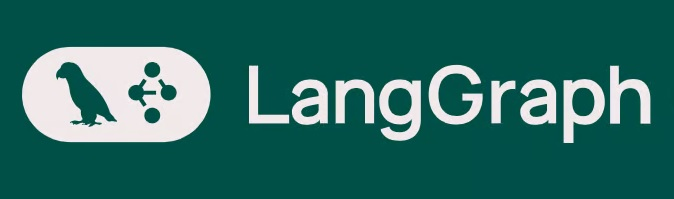

* Inspired by Google's Pregel system
* LangGraph models agent workflows as graphs (with nodes and edges).
* Its underlying graph algorithm uses messages passing to define a general program.
* When a node completes its execution, it sends messages along one or more edges to other node(s).
* Likewise, it propogates throughout the graph
* The execution proceeds in discrete "super-steps"

From Langgraph's Glossary:
>A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.

**Contents:**
- Basics
- Motivation
- Simple Graph
  - State
  - Nodes
  - Edges
  - Graph construction
  - Graph invocation
- Chains
- Messages
- Chat models
- Tools
- Reducers
- Router
- Agent
- Memory
- State schema
  - TypedDict
  - Dataclasses
  - Pydantic
- State reducers
  - add
  - rewrite
  - remove
- Multiple schemas
  - private state
  - input/output state
- Filtering and Trimming
  - Filtering messages
  - Trimming messages
- Running summary
  - Adding memory
  - Threads
- Message summarization with external db
  - Sqlite
- Streaming
  - Streaming tokens
- Breakpoints
- Human-in-the-loop
- Editing state
- Human feedback
- Dynamic breakpoints
- Time travel
  - Browsing history
  - Replaying
  - Forking
- Parallelization
  - Fan out and fan in
  - Order of updates
- Sub-graphs
- Map-reduce
- Long-term vs short-term memory
- Memory store
- Complex schemas (gemini doesnt work (as of 28-01-2025))
- Deployment (No langgraph cloud)

Project: **Research Assistant** (output failed, free version rate limit exceeded)
- Generate Analysts: Human-in-the-loop
- Conduct Interview
- Generate answer: Parallelization
- Write report
- Build the graph
- Parallelize interviews

## <span style="color:red">Basics</span>

In [64]:
from langchain_google_genai import ChatGoogleGenerativeAI
from keys import gemini_api_key
gemini_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    temperature=0,
    api_key=gemini_api_key
)

In [65]:
from langchain_core.messages import HumanMessage

In [4]:
msg = HumanMessage(content="heyy", name="apple")
messages = [msg]
gemini_llm.invoke(messages)

AIMessage(content='Hey there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c65f6c76-b82e-4ce7-8499-e8d0a94aa858-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

## <span style="color:red">Motivation</span>

A standalone llm has some limitations:
- Doesn't have access to tools
- Doesn't have access to external context
- Can't perform multi step operations

So, many LLM applications use a control flow with steps pre/post-LLM call (like tool calls and retrievals)

This control flow forms a **"chain"**

chain flows are predefined, and they are very reliable, the same flow occurs everytime we make a call.<br>
But we want the LLM system to make their own control flows


**Agent** ~ control flow defined by an LLM

2 (of many) kinds of Agents:<br>
- Router
  - Less control
  - More reliable
  - LLM controls a single step in a flow
- Fully Autonomous
  - High control
  - Less reliable
  - LLM can even autogenerate steps

Langgraph is making it possible to build fully autonomous agents with high reliablilty

> - LangGraph express custom control flows as **graphs**
> - **Nodes**: steps/functions
> - **edges**: connectivity between nodes

LangGraph features:
- State persistence
- Streaming
- Human-in-the-loop
- Controllability
- Cycles and Branching
- Long term memory
- Time travel

>- Langchain componenets are used in LangGraph often

## <span style="color:red">Simple Graph</span>

### <span style="color:purple">State</span>:
- The first thing to do, when you define your graph is define the **State** of the graph
- The **State** Scheme serves as the input schema for all Nodes and Edges in the graph
- **State** is global. All nodes operate on one State
- **State** is the class that represents the graph. You initialize by passing the state definition. 
- The state definition represents the central state object that is updated over time. This state is updated by nodes in the graph.
- State have attributes, which can be modified in 2 ways..
  - It can be overridden completely or updated by adding new value to it

In [22]:
from typing import TypedDict

class State(TypedDict):
    graph_state: str

### <span style="color:purple">Nodes</span>:
- Nodes are just python functions/chains/runnables
- For every node, State is its first positional argument
- By default, each node will override the prior state value

In [24]:
def node1(state):
    print("--Node 1--")
    return {"graph_state": state["graph_state"] + " I am"}

def node2(state):
    print("--Node 2--")
    return {"graph_state": state["graph_state"] + " happy!"}

def node3(state):
    print("--Node 3--")
    return {"graph_state": state["graph_state"] + " Sad!"}

### <span style="color:purple">Edges</span>:
- Connections between nodes
- Normal edge: 
  - a regular edge where the control flows from one node to another no matter what
- Conditional edge:
  - next node is decided based on a condition
  - it is implemented as a function that returns the next node to visit based upon some logic

In [26]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    user_input = state["graph_state"]
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

### <span style="color:purple">Graph construction</span>:

- The **"StateGraph"** class is the main graph class to use
- We initialize it with the **State** we defined
- Then we add the nodes and edges
- We use `START` node, a special node that sends user input to the graph, to indicate where to start our graph
- The `END` node is also a special node that represents the terminal node

In [24]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


builder = StateGraph(State)

builder.add_node("node_1", node1)
builder.add_node("node_2", node2)
builder.add_node("node_3", node3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

What does `.compile()` do?

* Compiling provides a few basic checks on the structure of the graph (eg., no orphan nodes, node validation etc..).
* It is also where we can specify runtime arguments like checkpointers and breakpoints.
* .compile() is a MUST before using the graph

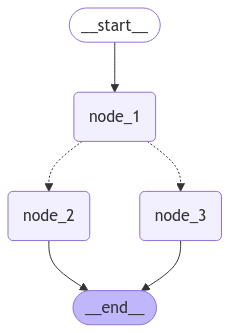

In [25]:
display(Image(graph.get_graph().draw_mermaid_png()))

### <span style="color:purple">Graph invocation</span>:

- The compiled graph implements the **runnable** protocol (a standard way to execute langchain components)
- Input dictionary with the attribute values are given in the `invoke` method
- Execution continues untill it reaches the `END` node

In [28]:
graph.invoke({"graph_state": "Hi, this is Person."})

--Node 1--
--Node 3--


{'graph_state': 'Hi, this is Person. I am Sad!'}

- `invoke` runs the entire graph synchronously i.e., it waits for each step to complete before moving to the next
- It returns the final state of the graph after all nodes have executed

## <span style="color:red">Chains</span>

- A sequence of LLM/function/tool calls
- Works the same everytime we invoke(static)
- hain componenets and control flow are predefined

## <span style="color:red">Messages</span>

- Chat models can use **messages**, which capture different roles within a conversation
- Various message types: AIMessage, HumanMessage, SystemMessage, ToolMessage which represents a message from the user, from the chat model, for the chat model to instruct behaviour, and from a tool call respectievely
- Each message has these attributes:
  - `content`: contents
  - `name`: optionally, who is creating the message
  - `response_metadata`: optionally, a dict of metadata that is often specific to each model provider

In [34]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = []
messages.extend([AIMessage(content="So you said you were researching ocean mammals?", name="model")])
messages.extend([HumanMessage(content="Yes, that's right", name="human")])
messages.extend([AIMessage(content="Great. What would you like to do about?", name="model")])
messages.extend([HumanMessage(content="I want to know the best places to see dolphins in my country", name="human")])

for m in messages:
    m.pretty_print()
    print()

================================== Ai Message ==================================
Name: model

So you said you were researching ocean mammals?

================================ Human Message =================================
Name: human

Yes, that's right

================================== Ai Message ==================================
Name: model

Great. What would you like to do about?

================================ Human Message =================================
Name: human

I want to know the best places to see dolphins in my country



## <span style="color:red">Chat Models</span>

A chat model is a language model that uses chat messages as inputs and returns chat messages as outputs (as opposed to using plain text).

In [37]:
result = gemini_llm.invoke(messages) # invoke with the above defined messages
type(result)

langchain_core.messages.ai.AIMessage

In [38]:
result

AIMessage(content="To give you the best recommendations for dolphin watching in your country, I need to know which country you're in!  Please tell me your country.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-dfe8e601-b82f-43b6-878a-46f99268d883-0', usage_metadata={'input_tokens': 42, 'output_tokens': 32, 'total_tokens': 74, 'input_token_details': {'cache_read': 0}})

## <span style="color:red">Tools</span>

- Tools are needed whenever you want a model to control parts of your code or call out to external APIs
- Gives the LLM additional knowledge which probably it didnt have

In [81]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b
    Args:
        a: first int
        b: second int
    """
    return a * b

tools = [multiply]
llm_with_tools = gemini_llm.bind_tools(tools)

In [42]:
tool_call = llm_with_tools.invoke([HumanMessage(content="what is 9 times 10?", name="Jesse")])
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 9.0, "b": 10.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-21853bea-80a3-4119-a028-f1f3d7cc549c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 9.0, 'b': 10.0}, 'id': '78e0f66e-637e-4cd5-a313-b3698a2b83f3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_tokens': 3, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}})

In [43]:
tool_call = llm_with_tools.invoke([HumanMessage(content="heyyy", name="Jesse")])
tool_call

AIMessage(content='Hello there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-877af9b7-e719-4d4b-922e-222c37205771-0', usage_metadata={'input_tokens': 63, 'output_tokens': 11, 'total_tokens': 74, 'input_token_details': {'cache_read': 0}})

In [44]:
from pprint import pprint
x = """AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 9.0, "b": 10.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ac5ad8ca-954e-4b8b-b9d8-21bfd215ad97-0', tool_calls=[{'name': 'multiply', 'args': {'a': 9.0, 'b': 10.0}, 'id': '268ba8db-8844-4108-bcff-94289d9be2ab', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_tokens': 3, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}})"""
pprint(x)

("AIMessage(content='', additional_kwargs={'function_call': {'name': "
 '\'multiply\', \'arguments\': \'{"a": 9.0, "b": 10.0}\'}}, '
 "response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': "
 "[]}, 'finish_reason': 'STOP', 'safety_ratings': []}, "
 "id='run-ac5ad8ca-954e-4b8b-b9d8-21bfd215ad97-0', tool_calls=[{'name': "
 "'multiply', 'args': {'a': 9.0, 'b': 10.0}, 'id': "
 "'268ba8db-8844-4108-bcff-94289d9be2ab', 'type': 'tool_call'}], "
 "usage_metadata={'input_tokens': 70, 'output_tokens': 3, 'total_tokens': 73, "
 "'input_token_details': {'cache_read': 0}})")


## <span style="color:orange">Combining them all together</span>

In [46]:
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## <span style="color:red">Reducers</span>

- When we have our State object, the nodes override its information everytime, this deletes all the previously stored, and puts new content there, but to keep track of messages, we dont want to override it, for this we have **reducer functions** to address the issue

- They allow us to specify how state updates are performed
- If no reducer function is explicitly specified, then it is assumed that all updates to the key should override it

In [49]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    ...


# LangGraph has a prebuilt MessageState that does the above job exactly
from langgraph.graph import MessagesState

class State(MessagesState):
    # anyother keys beyond messages, as that one is prebuilt
    ...



#both the above classes behave the same

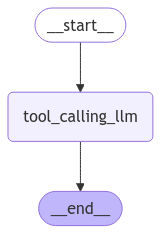

In [50]:
# State
class MessagesState(MessagesState):
    pass

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
graph.invoke({"messages": HumanMessage(content="Hello!")})

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='96f0c71f-edff-4e3c-9462-bc6343ea03bf'),
  AIMessage(content='Hello! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e57af17a-cb21-4269-b716-a604ae5c4d4b-0', usage_metadata={'input_tokens': 63, 'output_tokens': 10, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}})]}

- The AI Message is just a regular natural language response 

In [52]:
graph.invoke({"messages": HumanMessage(content="What is 9 times 10?")})

{'messages': [HumanMessage(content='What is 9 times 10?', additional_kwargs={}, response_metadata={}, id='acfe435e-979f-42fa-a5d5-4cd91a82519f'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 9.0, "b": 10.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f3b02fc3-34ff-489a-88b3-687ea3b39602-0', tool_calls=[{'name': 'multiply', 'args': {'a': 9.0, 'b': 10.0}, 'id': '5c170d5d-840e-48c9-b8dc-f90c9c44defd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_tokens': 3, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}})]}

- The AI Message now is a tool call

## <span style="color:red">Router</span>

- right now, the graph can return a tool call or return a natural language response
- Now we want the chat model to route between direct response or a tool call based on user input

Now, let's implement this way if the model returns a "tool_call", we can execute that tool

- We can use the built in `ToolNode` and simply pass a list of our tools to initialize it

In [58]:
from langgraph.prebuilt import ToolNode
tools = [multiply]
tool_node = ToolNode(tools)

def maybe_route_to_tools(state: MessagesState) -> str:
    msgs = state.get("messages", [])
    msg = msgs[-1]
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return END

In [59]:
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", tool_node)

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", maybe_route_to_tools)
builder.add_edge("tools", END)

graph = builder.compile()

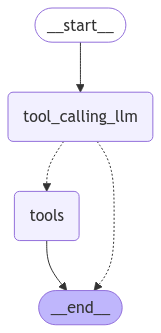

In [60]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
messages = [HumanMessage(content="Multiply 9 and 10")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 9 and 10
================================== Ai Message ==================================
Tool Calls:
  multiply (137fef8d-1111-4279-bac6-fe46daa6cfe4)
 Call ID: 137fef8d-1111-4279-bac6-fe46daa6cfe4
  Args:
    a: 9.0
    b: 10.0
================================= Tool Message =================================
Name: multiply

90


In [62]:
messages = [HumanMessage(content="heyyy")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

heyyy
================================== Ai Message ==================================

Hello there! How can I help you today?


## <span style="color:red">Agent</span>

- Take the output of tools node (ToolMessage) and send it back to the chat_model
- This is the intuition behind **ReAct**, a general agent architecture
  - **act**- Let the model call specific tools
  - **observe**- pass the tool output back to the model
  - **reason**- Let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [68]:
def add(a: int, b: int) -> int:
    """
    Adds a and b
    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """
    Subtracts b from a
    Args:
        a: first int
        b: second int
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """
    Multiply a and b
    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> int:
    """
    Divides a by b
    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, subtract, multiply, divide]
llm = ChatGoogleGenerativeAI(
    temperature=0,
    model="gemini-1.5-flash",
    api_key=gemini_api_key
)
llm_with_tools = llm.bind_tools(tools)

In [188]:
from langgraph.graph import MessagesState
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

tool_node = ToolNode(tools)

def assistant_node(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


def route_to_tools(state: MessagesState) -> str:
    msgs = state.get("messages", [])
    msg = msgs[-1]
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return END

- As before, we use `MessagesState` and define a `tool_node`
- The `assistant_node` is just our chat_model bound to tools
- We create a graph just like before except now, we have an additional step
We connect the tool_node back to the `assistant_node`, forming a loop
<br><br>
- The loop continues as long as the model decides to call tools.
- If the model response is not a tool call, the flow is directed to `END`, terminating the process.

In [191]:
from langgraph.prebuilt import tools_condition
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant_node)
builder.add_node("tools", tool_node)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", route_to_tools)
# or
#builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()

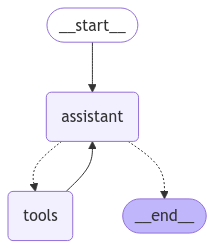

In [193]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [195]:
messages = [HumanMessage(content="Add 11 and 9. Multiply the output by 5. Subtract 25 from its output. And Divide the output by 3.")]
response_messages = graph.invoke({"messages": messages})

In [196]:
from IPython.display import display, Markdown
for m in response_messages["messages"]:
    if m == response_messages["messages"][-1]:
        display(Markdown(m.content))
    else:
        Markdown(m.pretty_print())

================================ Human Message =================================

Add 11 and 9. Multiply the output by 5. Subtract 25 from its output. And Divide the output by 3.
================================== Ai Message ==================================
Tool Calls:
  add (4b674c60-c017-409d-8e73-cbb285f44d8f)
 Call ID: 4b674c60-c017-409d-8e73-cbb285f44d8f
  Args:
    a: 11.0
    b: 9.0
  multiply (d5475e9b-66b2-4266-8f65-493b4edffcf7)
 Call ID: d5475e9b-66b2-4266-8f65-493b4edffcf7
  Args:
    a: 20.0
    b: 5.0
  subtract (2db9f480-62c0-4b00-9c0f-d191be7a8174)
 Call ID: 2db9f480-62c0-4b00-9c0f-d191be7a8174
  Args:
    a: 100.0
    b: 25.0
  divide (f0e1872f-b503-4ebb-84b6-494cfb68869b)
 Call ID: f0e1872f-b503-4ebb-84b6-494cfb68869b
  Args:
    a: 75.0
    b: 3.0
================================= Tool Message =================================
Name: add

20
================================= Tool Message =================================
Name: multiply

100
=========================

Here's the solution:

1. **Add 11 and 9:** 11 + 9 = 20
2. **Multiply by 5:** 20 * 5 = 100
3. **Subtract 25:** 100 - 25 = 75
4. **Divide by 3:** 75 / 3 = 25

The final answer is $\boxed{25}$


## <span style="color:red">Memory</span>

- Each graph invocation is independent
- We don't retain the previous conversations
- The State is transient to a single graph execution
- We can have persistence to address this issue.
- LangGraph can use a checkpointer to automatically save the graph state after each step
- This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update
- One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state

In [205]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

- When we use memory, we need to specify a `thread_id`
- This will store our collection of graph states
- The checkpointer write the state at every step of the graph
- These checkpointers are saved in a thread
- We can access the thread in the future using the `thread_id`

In [207]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="Add 9 and 10")]
messages = graph_memory.invoke({"messages": messages}, config)

In [209]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 9 and 10
================================== Ai Message ==================================
Tool Calls:
  add (24cf8e32-a342-4b38-87b2-c3bfe8ba8623)
 Call ID: 24cf8e32-a342-4b38-87b2-c3bfe8ba8623
  Args:
    a: 9.0
    b: 10.0
================================= Tool Message =================================
Name: add

19
================================== Ai Message ==================================

The sum of 9 and 10 is 19.


In [211]:
messages = [HumanMessage(content="Now multiply that by 25")]
messages = graph_memory.invoke({"messages": messages}, config)

In [213]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 9 and 10
================================== Ai Message ==================================
Tool Calls:
  add (24cf8e32-a342-4b38-87b2-c3bfe8ba8623)
 Call ID: 24cf8e32-a342-4b38-87b2-c3bfe8ba8623
  Args:
    a: 9.0
    b: 10.0
================================= Tool Message =================================
Name: add

19
================================== Ai Message ==================================

The sum of 9 and 10 is 19.
================================ Human Message =================================

Now multiply that by 25
================================== Ai Message ==================================
Tool Calls:
  multiply (eb229248-1bce-4a3b-a885-711dd6410c7d)
 Call ID: eb229248-1bce-4a3b-a885-711dd6410c7d
  Args:
    a: 19.0
    b: 25.0
================================= Tool Message =================================
Name: multiply

475
================================== Ai Message ==========

<br><br>NOTE: **If you change the `thread_id`, you change the state**

## <span style="color:red">State Schema</span>

- Schema represents the structure and types of data that our graph will use
- All nodes are expected to communicate with that schema
- LangGraph offers flexibility in how we define our state schema, accommodating various Python types and their corresponding value types

### <span style="color:purple">TypedDict</span>:

- `TypedDict` is an official Python dictionary subclass that allows us to specify keys and their corresponding value types.
- Note that they are **type hints**
- They can be used by static type checkers and IDEs to catch potential type related errors **before** the code is run
- They are **NOT** enforced at runtime

In [43]:
from typing import TypedDict, Literal
class TypedDictState(TypedDict):
    graph_state: str
    mood: Literal["happy", "sad"]

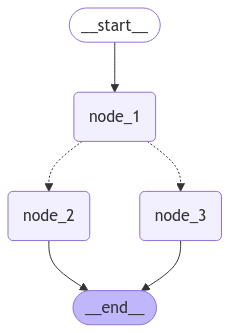

In [45]:
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node1)
builder.add_node("node_2", node2)
builder.add_node("node_3", node3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
graph.invoke({"graph_state": "chang chang"})

--Node 1--
--Node 3--


{'graph_state': 'chang chang I am Sad!'}

### <span style="color:purple">Dataclasses</span>:

- Similar to TypedDict
- Another way to define (annotate) structured data

In [66]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    graph_state: str
    mood: Literal["happy", "Sad"]


#### The only difference is

##### 1. now we can't subscript

Old:

```python
return {"graph_state": state["graph_state"] + " I am"}
```

New:

```python
return {"graph_state": state.graph_state + " I am"}
```

##### 2. and we invoke differently

Old:

```python
graph.invoke({"graph_state": "chang chang"})
```

New:

```python
graph.invoke(DataclassState(graph_state="chang chang"))
```

### <span style="color:purple">Pydantic</span>:

- As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime.
- This means the datatype is not validated, and you can assign values with the incorrect data type without any errors

- Pydantic is a powerful data validation and settings management library using Python type annotations
- It's particularly well-suited for defining state schemas in LangGraph due to its robust validation capabilities
- IT performs validation at runtime to confirm whether data match to their specified types

In [119]:
from langchain_core.pydantic_v1 import BaseModel, validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: Literal["happy", "sad"]

    # @validator("mood")
    # def validate_mood(cls, value):
    #     if value not in ["happy", "sad"]:
    #         raise ValueError("Each mood must be either 'happy' or 'sad'")
    #     return value

try:
    state = PydanticState(name="Doe Doe", mood="chirp")
except ValidationError as e:
    print("ValidationError:", e)

ValidationError: 1 validation error for PydanticState
mood
  unexpected value; permitted: 'happy', 'sad' (type=value_error.const; given=chirp; permitted=('happy', 'sad'))


- **NOTE**: The syntax for `pydantic` is just like `dataclasses`

## <span style="color:red">State Reducers</span>

- when two nodes are in parallel and both operate on a key, langgraph raises an error knowing which of those 2 nodes' value must be kept for that key in the state schema

**NOTE**: By default, when we make updates, we overwrite the prior value

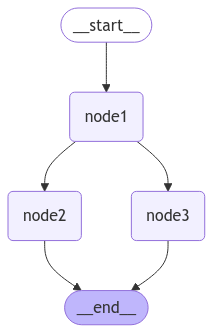

In [35]:
class State(TypedDict):
    graph_state: int
    
def node1(state):
    return {"graph_state": state["graph_state"] + 1}

def node2(state):
    return {"graph_state": state["graph_state"] + 1}

def node3(state):
    return {"graph_state": state["graph_state"] + 1}

builder = StateGraph(State)

builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

builder.add_edge("node1", "node2")
builder.add_edge("node1", "node3")

builder.add_edge(START, "node1")
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"graph_state": 1})
except InvalidUpdateError as e:
    print("InvalidUpdateError:", e)

InvalidUpdateError: At key 'graph_state': Can receive only one value per step. Use an Annotated key to handle multiple values.


- Before for the "happy" and "sad" example, we used a conditional edge, here we directly pass the state to both the nodes in parallel

**Reducers** give us a general way to address this problem

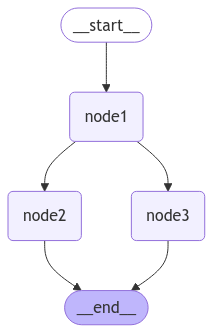

In [59]:
from operator import add
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict

class State(TypedDict):
    graph_state: Annotated[list[int], add]

def node1(state):
    return {"graph_state": [905]}

def node2(state):
    return {"graph_state": [state["graph_state"][-1]-100]}

def node3(state):
    return {"graph_state": [907]}

builder = StateGraph(State)

builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

builder.add_edge("node1", "node2")
builder.add_edge("node1", "node3")

builder.add_edge(START, "node1")
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
graph.invoke({"graph_state": [2]})

{'graph_state': [2, 905, 805, 907]}

### <span style="color:purple">add</span>:

In [5]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

initial_messages = [
    AIMessage(content="Hey there!", id=1),
    HumanMessage(content="I am tree", id=2)
]
new_message = AIMessage(content="sure, Hi", id=3)
add_messages(initial_messages, new_message)

[AIMessage(content='Hey there!', additional_kwargs={}, response_metadata={}, id='1'),
 HumanMessage(content='I am tree', additional_kwargs={}, response_metadata={}, id='2'),
 AIMessage(content='sure, Hi', additional_kwargs={}, response_metadata={}, id='3')]

### <span style="color:purple">re-write</span>:

In [11]:
new_msg= HumanMessage(content="I am mike", id=2)
add_messages(initial_messages, new_msg)

[AIMessage(content='Hey there!', additional_kwargs={}, response_metadata={}, id='1'),
 HumanMessage(content='I am mike', additional_kwargs={}, response_metadata={}, id='2')]

### <span style="color:purple">remove</span>:

In [16]:
from langchain_core.messages import RemoveMessage
initial_messages

[AIMessage(content='Hey there!', additional_kwargs={}, response_metadata={}, id='1'),
 HumanMessage(content='I am tree', additional_kwargs={}, response_metadata={}, id='2')]

In [22]:
add_messages(initial_messages, RemoveMessage(id=1))

[HumanMessage(content='I am tree', additional_kwargs={}, response_metadata={}, id='2')]

## <span style="color:red">Multiple Schemas</span>

- Typically all graph nodes communicate with a single schema
- This single schema consists of graph's input and output keys/channels
- But there are cases:
  - Internal nodes may pass information that is not required in the graph's input/output
  - We may also want to use different input/output schemas for the graph. The output might only contain a single relevant output key

### <span style="color:purple">private state</span>:

This is useful for anything needed as part of the intermediate working logic of the graph but not relevant for the overall graph input or output

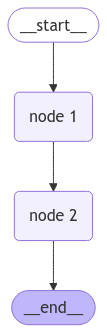

In [29]:
from typing import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    return {"baz": state["foo"] + 1}

def node_2(state: PrivateState) -> OverallState:
    return {"foo": state["baz"] + 1}

builder = StateGraph(OverallState)
builder.add_node("node 1", node_1)
builder.add_node("node 2", node_2)

builder.add_edge(START, "node 1")
builder.add_edge("node 1", "node 2")
builder.add_edge("node 2", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
graph.invoke({"foo": 1})

{'foo': 3}

`baz` is private to this graph <br>
"node 2" uses `PrivateState` as input but writes out to `OverallState`

### <span style="color:purple">Input/Output State</span>:

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. However, it is also possible to define explicit input and output schemas for a graph.<br>
In these cases, we define and "internal" schema that contains all keys relevant to graph operations

In [37]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name Bond"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "Farewell Mr. Bond"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("thinking_node", thinking_node)
graph.add_node("answer_node", answer_node)

graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

In [39]:
graph.invoke({"question": "hi"})

{'answer': 'Farewell Mr. Bond'}

- As we can see, the `Output` schema constrains the output to only the `answer` key

## <span style="color:red">Filtering and trimming messages</span>

In [43]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage(content="So you said you were researching about fruits?", name="Bot"),
    HumanMessage(content="Yes, I know about pineapples. But what others should I learn about?", name="Human")
]

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about fruits?
================================ Human Message =================================
Name: Human

Yes, I know about pineapples. But what others should I learn about?


In [47]:
from langchain_google_genai import ChatGoogleGenerativeAI
from keys import gemini_api_key
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", google_api_key=gemini_api_key)

In [49]:
llm.invoke(messages)

AIMessage(content="That's great you know about pineapples!  To suggest other fruits for you to learn about, I need a little more information about your interests.  What aspects of fruit are you most interested in?  For example, are you interested in:\n\n* **Nutritional value:**  Then you might want to research fruits high in Vitamin C (like oranges, kiwis, and strawberries), antioxidants (like blueberries and acai berries), or fiber (like apples and pears).\n* **Geographical origins and cultivation:**  Learning about the history and growing conditions of fruits like mangoes (India), bananas (Southeast Asia), or avocados (Mexico) could be fascinating.\n* **Culinary uses:**  Explore fruits used in desserts (like berries, cherries, and mangoes), savory dishes (like tomatoes, pomegranates, and citrus fruits), or beverages (like grapes, cranberries, and passion fruit).\n* **Unique characteristics:**  Learn about unusual fruits like durian (known for its pungent smell), mangosteen (for its s

In [51]:
from langgraph.graph import MessagesState
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()


In [53]:
output = graph.invoke({"messages": messages})
for m in output["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about fruits?
================================ Human Message =================================
Name: Human

Yes, I know about pineapples. But what others should I learn about?
================================== Ai Message ==================================

That's great you know about pineapples!  To suggest other fruits for you to learn about, I need a little more information about your interests.  What aspects of fruit are you most curious about?  For example, are you interested in:

* **Nutritional aspects?**  (e.g., vitamin content, antioxidants, health benefits)  If so, I could suggest fruits high in specific nutrients or with unique health properties.
* **Geographic origins and cultivation?** (e.g., where they grow, the history of their cultivation)
* **Culinary uses?** (e.g., how they're prepared in different cuisines, common recipes)
* **Botanical classif

- A practical issue in working with messages is, managing long running conversations
- Costly, in terms of latency, token count etc..

One way to handle this problem is to filter the messages: (Remove all messages except the last two)

In [62]:
def filter_messages(State: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

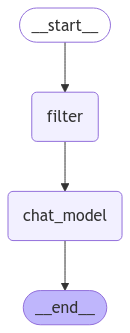

In [66]:
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

This will only send the two most recent messages to the LLM, and after execution, there will be only three messages

### <span style="color:purple">Filtering messages</span>:

If you do not wish to modify the graph state, you can just filter the messages you pass to the chat model

```python
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}
```

### <span style="color:purple">Trimming messages</span>:

- based upon on a set number of tokens

- this restricts the message history to a specified number of tokens
- While filtering, only returns a post-hoc subset of the messages between graphs, trimming restricts the number of tokens that a chat model can use to respond

In [80]:
from langchain_core.messages import trim_messages

def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", google_api_key=gemini_api_key),
        allow_partial=False
    )
    return {"messages": [llm.invoke(messages)]}

In [78]:
messages

[AIMessage(content='So you said you were researching about fruits?', additional_kwargs={}, response_metadata={}, name='Bot', id='fef09018-4e32-4a0b-899e-a6b0dce575ae'),
 HumanMessage(content='Yes, I know about pineapples. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Human', id='dc0fb73e-4865-48ab-b07b-fe821830d98e')]

In [88]:
trim_messages(
    messages,
    max_tokens=20, # this parameter determines
    strategy="last",
    token_counter=ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", google_api_key=gemini_api_key),
    allow_partial=False
)

[HumanMessage(content='Yes, I know about pineapples. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Human', id='dc0fb73e-4865-48ab-b07b-fe821830d98e')]

## <span style="color:red">Running summary</span>

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
from keys import gemini_api_key
from langchain_core.messages import RemoveMessage

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState


class State(MessagesState):
    summary: str

model = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", google_api_key=gemini_api_key)

def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

- we use `RemoveMessage` to filter our state after we've produced the summary

In [5]:
def call_model(state: State):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

- We will add a conditional edge to determine whether to produce a summary based on the conversation length

In [7]:
def should_continue(state: State):
    messages = state["messages"]
    length = 6 # change howmuchever you want
    if len(messages) > length:
        return "summarize_conversation"
    else:
        return END

### <span style="color:purple">Adding memory</span>:

- Recall that state is *transient* to a single graph execution
- This limits out ability to have multi-turn conversations with interruptions
- we can use *persistence*; a checkpointer to automatically save the graph state after each step
- This built-in persistence layer gives us memory, allowing Langgraph to pick up from the last state update

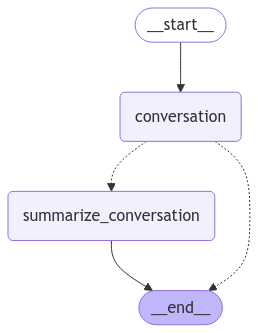

In [9]:
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### <span style="color:purple">Threads</span>:

Threads represent individual sessions or conversations between the graph and a user. When using checkpointing, turns in a single conversation (and even steps within a single graph execution) are organized by a unique thread ID.

- The checkpointer saves the state at each step as a checkpoint
- These saved checkpoints can be grouped into a thread of conversation

In [17]:
from langchain_core.messages import HumanMessage
config = {"configurable": {"thread_id": "2"}}

input_msg = HumanMessage(content="hi! I am Bond")
output = graph.invoke({"messages": [input_msg]}, config)
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi! I am Bond
================================== Ai Message ==================================

Hello Bond.  Is there anything I can help you with today?


**Now, a seperate invocation:**

In [19]:
config = {"configurable": {"thread_id": "2"}}

input_msg = HumanMessage(content="who was i?")
output = graph.invoke({"messages": [input_msg]}, config)  # make sure the config is same
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi! I am Bond
================================== Ai Message ==================================

Hello Bond.  Is there anything I can help you with today?
================================ Human Message =================================

who was i?
================================== Ai Message ==================================

You said you are Bond.  That's James Bond, the fictional British secret agent created by Ian Fleming.


**view the state saved in the thread:**

In [21]:
graph.get_state(config).values.get("messages", "")

[HumanMessage(content='hi! I am Bond', additional_kwargs={}, response_metadata={}, id='d76f299a-4ce1-4a7e-bc0b-2e9925e3ecea'),
 AIMessage(content='Hello Bond.  Is there anything I can help you with today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-723c82eb-c09f-4faf-b8e0-cfc26d21ad5e-0', usage_metadata={'input_tokens': 6, 'output_tokens': 15, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}}),
 HumanMessage(content='who was i?', additional_kwargs={}, response_metadata={}, id='050f9450-65c1-43bb-9f89-95ad05cf27c7'),
 AIMessage(content="You said you are Bond.  That's James Bond, the fictional British secret agent created by Ian Fleming.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-564249c4-61e6-4e4e-8778-02ab945a1efc-0', usage_metadata={'inpu

In [23]:
graph.get_state(config).values.get("summary", "")

''

In [25]:
config = {"configurable": {"thread_id": "2"}}

input_msg = HumanMessage(content="who is better at our job, me or Agent P?")
output = graph.invoke({"messages": [input_msg]}, config)  # make sure the config is same
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi! I am Bond
================================== Ai Message ==================================

Hello Bond.  Is there anything I can help you with today?
================================ Human Message =================================

who was i?
================================== Ai Message ==================================

You said you are Bond.  That's James Bond, the fictional British secret agent created by Ian Fleming.
================================ Human Message =================================

who is better at our job, me or Agent P?
================================== Ai Message ==================================

That's a fun question!  Comparing James Bond and Agent P (Perry the Platypus from Phineas and Ferb) is tricky because they operate in very different contexts and have vastly different skill sets.

* **James Bond:**  Is a highly trained, sophisticated spy specializing in espionage, 

In [27]:
config = {"configurable": {"thread_id": "2"}}

input_msg = HumanMessage(content="How many times each of our identity was compromised?")
output = graph.invoke({"messages": [input_msg]}, config)  # make sure the config is same
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

How many times each of our identity was compromised?
================================== Ai Message ==================================

This is a difficult question to answer definitively, as it depends on how you define "compromised identity."

* **James Bond:**  His identity has been compromised numerous times throughout the various books and films.  His cover has been blown, his true identity suspected or revealed, and he's been impersonated.  There isn't a single number, as it's a recurring theme in his stories.  The level of compromise also varies – sometimes it's a temporary setback, and sometimes it's a major plot point.

* **Agent P:**  His dual identity as Perry the Platypus and a secret agent is generally well-protected within the show's universe.  While his cover might be threatened occasionally, his identity as Agent P is rarely truly "compromised" in the way Bond's might be.  He faces threats,

In [29]:
graph.get_state(config).values.get("messages", "")

[HumanMessage(content='How many times each of our identity was compromised?', additional_kwargs={}, response_metadata={}, id='b72dc110-d377-441b-a529-79940cce2cfd'),
 AIMessage(content='This is a difficult question to answer definitively, as it depends on how you define "compromised identity."\n\n* **James Bond:**  His identity has been compromised numerous times throughout the various books and films.  His cover has been blown, his true identity suspected or revealed, and he\'s been impersonated.  There isn\'t a single number, as it\'s a recurring theme in his stories.  The level of compromise also varies – sometimes it\'s a temporary setback, and sometimes it\'s a major plot point.\n\n* **Agent P:**  His dual identity as Perry the Platypus and a secret agent is generally well-protected within the show\'s universe.  While his cover might be threatened occasionally, his identity as Agent P is rarely truly "compromised" in the way Bond\'s might be.  He faces threats, but outright exposu

In [31]:
graph.get_state(config).values.get("summary", "")

"The conversation began with a playful introduction where the user identified as James Bond.  We then discussed the relative merits of James Bond and Agent P as secret agents, acknowledging their vastly different contexts and skill sets – Bond operating in a world of realistic espionage and Agent P in a comedic, cartoon world.  Finally, we debated the difficulty of quantifying how many times each agent's identity had been compromised, concluding that while Bond's identity is frequently threatened and revealed to varying degrees, Agent P's secret identity remains largely secure within the parameters of his show.\n"

## <span style="color:red">Message summarization with external database</span>

### <span style="color:purple">Sqlite</span>

In [40]:
import sqlite3

- Sqlite is a small, fast and highly popular SQL database
- If we supply `":memory:"`, it creates an in-memory Sqlite database just as we've done before

**NOTE:** This is only lasts till the lifetime of this notebook, replace with an actual local db to persist for a longer time

In [43]:
conn = sqlite3.connect(":memory:")

- If you supply a path, then it will create a db for us

In [49]:
db_path = "example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [53]:
!pip install langgraph-checkpoint-sqlite -q

In [58]:
from langgraph.checkpoint.sqlite import SqliteSaver
new_memory = SqliteSaver(conn)

- just recompile it with our new memory

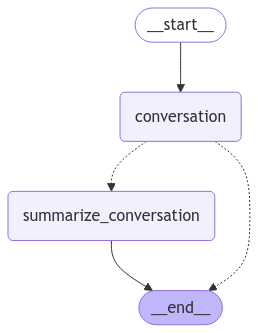

In [60]:
class State(MessagesState):
    summary: str

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=new_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

**Create a new thread**

Just print the last message (AIMessage) of the messages each time

In [64]:
config = {"configurable": {"thread_id": "142"}}

input_message = HumanMessage(content="Hi! i am carl johnson")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="who did i say i was?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I killed Big Smoke")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hey Carl Johnson!  What's up?  Hope things are going better in San Andreas than they used to. 😉
================================== Ai Message ==================================

You said you were Carl Johnson, the protagonist from the video game Grand Theft Auto: San Andreas.
================================== Ai Message ==================================

That's right, Carl.  A pivotal moment in the game.  Justice served (or at least, your version of it).


**Confim that the state is saved locally**

In [69]:
config = {"configurable": {"thread_id": "142"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Hi! i am carl johnson', additional_kwargs={}, response_metadata={}, id='e863ff6c-8071-4873-b937-75107ba1d017'), AIMessage(content="Hey Carl Johnson!  What's up?  Hope things are going better in San Andreas than they used to. 😉\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e996c6c3-c276-40fe-9070-e12be3a6f80f-0', usage_metadata={'input_tokens': 7, 'output_tokens': 26, 'total_tokens': 33, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='who did i say i was?', additional_kwargs={}, response_metadata={}, id='c73b0d88-e5b6-441a-8751-8cc380a0561f'), AIMessage(content='You said you were Carl Johnson, the protagonist from the video game Grand Theft Auto: San Andreas.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_r

**Now, even if the notebook session ends and restarts, these messages will persist**

## <span style="color:red">Streaming</span>

Ways to stream our graph state:
- `.stream` and `.astream` are sync and async methods for streaming back results

Langgraph has these streaming modes for the graph state:
- `values` : Streams the full state of the graph after each node is called.
- `updates` : Streams updates to the state of the graph after each node is run

- **mode = "updates"**:

{"messages":["a"]} -> {"messages":["b"]} -> {"messages":["c"]}


- **mode = "values"**:

{"messages":["a"]} -> {"messages":["a", "b"]} -> {"messages":["a", "b", "c"]}


Each chunk of the stream output is a dictionary: {node_name : updated state}

In [31]:
config = {"configurable": {"thread_id": "22-01-25"}}

inp_msg = HumanMessage(content="hi! I am Joe")
for chunk in graph.stream({"messages": [inp_msg]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Joe!  How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e5ab6ef2-3279-46f9-8dbf-6b8c1dbfd684-0', usage_metadata={'input_tokens': 6, 'output_tokens': 12, 'total_tokens': 18, 'input_token_details': {'cache_read': 0}})}}


In [33]:
config = {"configurable": {"thread_id": "22-01-25-2"}}

inp_msg = HumanMessage(content="hi! I am Joe")
for chunk in graph.stream({"messages": [inp_msg]}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='hi! I am Joe', additional_kwargs={}, response_metadata={}, id='80b013c4-52b2-4d18-9049-836cea2de0a4')]}
{'messages': [HumanMessage(content='hi! I am Joe', additional_kwargs={}, response_metadata={}, id='80b013c4-52b2-4d18-9049-836cea2de0a4'), AIMessage(content='Hi Joe!  How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c7082500-3c6c-4498-b5eb-833db34f8a3f-0', usage_metadata={'input_tokens': 6, 'output_tokens': 12, 'total_tokens': 18, 'input_token_details': {'cache_read': 0}})]}


### <span style="color:purple">Streaming tokens</span>

- It is common to stream the tokens as they are generated
- We can do this using the `.astream_events` , which streams back events as they happen inside the nodes

Each event is a dictionary with few keys:
- `event` : Type of event that is being emitted.
- `name` : Name of the event
- `data` : Data associated with the event
- `metadata` : Which contains `langgraph_node` , the node emitting the event 

In [43]:
config = {"configurable": {"thread_id": "22-01-25-2"}}
input_message = HumanMessage(content="What's in the box?????")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node', '')}, Type: {event['event']}, Name:: {event['name']}")

Node: , Type: on_chain_start, Name:: LangGraph
Node: __start__, Type: on_chain_start, Name:: __start__
Node: __start__, Type: on_chain_start, Name:: _write
Node: __start__, Type: on_chain_end, Name:: _write
Node: __start__, Type: on_chain_start, Name:: _write
Node: __start__, Type: on_chain_end, Name:: _write
Node: __start__, Type: on_chain_stream, Name:: __start__
Node: __start__, Type: on_chain_end, Name:: __start__
Node: conversation, Type: on_chain_start, Name:: conversation
Node: conversation, Type: on_chat_model_start, Name:: ChatGoogleGenerativeAI
Node: conversation, Type: on_chat_model_stream, Name:: ChatGoogleGenerativeAI
Node: conversation, Type: on_chat_model_stream, Name:: ChatGoogleGenerativeAI
Node: conversation, Type: on_chat_model_stream, Name:: ChatGoogleGenerativeAI
Node: conversation, Type: on_chat_model_end, Name:: ChatGoogleGenerativeAI
Node: conversation, Type: on_chain_start, Name:: _write
Node: conversation, Type: on_chain_end, Name:: _write
Node: conversation, 

* The tokens from chat models in our graph have the `on_chat_model_stream` type.
* We can use `event['data']['langgraph_node']`  to select the node to stream from
* We can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`

In [50]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "22-01-25-3"}}
input_messsage = HumanMessage(content="Whats in tha boooxxx???")

async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run-93fad91d-e8b1-4410-b2e9-e3121d1929ed', usage_metadata={'input_tokens': 8, 'output_tokens': 0, 'total_tokens': 8, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=" contents of the box are a mystery!  To know what's in the", additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run-93fad91d-e8b1-4410-b2e9-e3121d1929ed', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=' box, I need more information.  Is this a riddle?  A reference', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run-93fad91d-e8b1-4410-b2e9-e3121d1929ed', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=' to a movie or story?  Tell me more!', additi

In [64]:
config = {"configurable": {"thread_id": "622-01-25-6"}}
input_messsage = HumanMessage(content="Its a famous quote from a movie.. guess which?")
async for event in graph.astream_events({"messages": [input_messsage]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node", "") == node_to_stream:
        print(event["data"]["chunk"].content)

"
What's in the box?" is a famous line from **Seven (Se
7en)**.


## <span style="color:red">Breakpoints</span>

Allows us to stop the graph at specific steps

Let's use some basic arithmetic tools which we used at the beginning

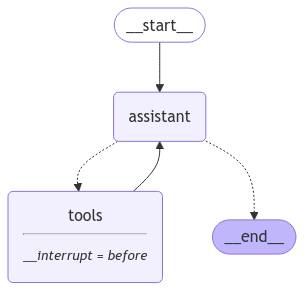

In [103]:
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_edge("tools", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [105]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = {"configurable": {"thread_id": "112"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (230cff26-4f01-4fb9-b697-e57c10a82211)
 Call ID: 230cff26-4f01-4fb9-b697-e57c10a82211
  Args:
    a: 2.0
    b: 3.0


We have reached the tools node, and we have stopped BEFORE executing the logic of that node

In [110]:
state = graph.get_state(thread)
state.next  # what node is going to be invoked/called next

('tools',)

In [129]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='883f6615-98fe-4056-8e95-077862085dbb'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d38763ef-8202-40b3-9543-97a1737f78f2-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '230cff26-4f01-4fb9-b697-e57c10a82211', 'type': 'tool_call'}], usage_metadata={'input_tokens': 265, 'output_tokens': 3, 'total_tokens': 268, 'input_token_details': {'cache_read': 0}})]}, next=('tools',), config={'configurable': {'thread_id': '112', 'checkpoint_ns': '', 'checkpoint_id': '1efd89ab-d391-62e5-8001-b94af48d75be'}}, metadata={'source': 'loop', 'writes': {'assistant': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply

* Each graph has a number of super steps
* Each step (as our graph executes) has a state, which is written by a checkpointer (as a checkpoint)
* Checkpoint contains the state and other useful metadata
* A thread is a collection of checkpoints
* A StateSnapshot is a 'type' of checkpoint

So now, we have the `StateSnapshot()` which allows us to resume the execution after we interrupted it with the breakpoint

```python
thread = {"configurable": {"thread_id": "112"}}
graph.stream(None,  thread, stream_mode="values")
```

* LangGraph will re-emit the current state, which contains the `AIMessage` with the tool call
* And then it will proceed to execute the following step in the graph, which start with the tool node

In [137]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (230cff26-4f01-4fb9-b697-e57c10a82211)
 Call ID: 230cff26-4f01-4fb9-b697-e57c10a82211
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result is 6.


Now, we can introduce user input

## <span style="color:red">Human-in-the-loop</span>

Motivation for human-in-the-loop:
* **Approval**: We can interrupt our agent, surface state to a user, and allow the user to accept an action
* **Debugging**: We can rewind the graph to reproduce or avoid issues
* **Editing**: You can modify the state

In [141]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = {"configurable": {"thread_id": "2"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

print("Do you want to call the tool (yes/no): ")

user_approval = input("Do you want to call the tool (yes/no): ")
print(user_approval)
if user_approval.lower() == "yes":
    for event in graph.stream(None, thread, stream_mode="values"):
        event["messages"][-1].pretty_print()
else:
    print("Operation cancelled by user")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (b83a6b6a-fb85-4bb9-aa98-8b9fd037a6c3)
 Call ID: b83a6b6a-fb85-4bb9-aa98-8b9fd037a6c3
  Args:
    a: 2.0
    b: 3.0
Do you want to call the tool (yes/no): 


Do you want to call the tool (yes/no):  yes


yes
================================== Ai Message ==================================
Tool Calls:
  multiply (b83a6b6a-fb85-4bb9-aa98-8b9fd037a6c3)
 Call ID: b83a6b6a-fb85-4bb9-aa98-8b9fd037a6c3
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result is 6.


## <span style="color:red">Editing state</span>

Breakpoints not only interrupt the execution but also provides us an opportunity to modify the graph state

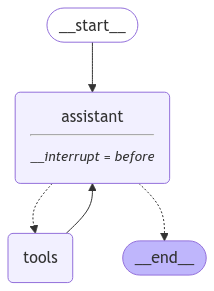

In [146]:
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_edge("tools", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [148]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = {"configurable": {"thread_id": "119"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [150]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='26286efd-3b83-4cad-9cef-e7dfe615cd1d')]}, next=('assistant',), config={'configurable': {'thread_id': '119', 'checkpoint_ns': '', 'checkpoint_id': '1efd8b10-adc3-6ffd-8000-f75b90a38586'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '119', 'step': 0, 'parents': {}}, created_at='2025-01-22T11:07:17.479218+00:00', parent_config={'configurable': {'thread_id': '119', 'checkpoint_ns': '', 'checkpoint_id': '1efd8b10-adbc-6a89-bfff-73ef52aa426c'}}, tasks=(PregelTask(id='914a6d0c-07f2-78c7-0dc7-08651ec2eaa5', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [152]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 4!")]}
)

{'configurable': {'thread_id': '119',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd8b12-f603-6cd3-8001-8d7ea589291f'}}

In [154]:
new_state = graph.get_state(thread).values
for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 4!


* The state class uses reducers for the "messages" key, so new changes are getting appended

In [159]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 4!
================================== Ai Message ==================================
Tool Calls:
  multiply (f2904a4c-ca45-4124-ac51-2bf6e8db3e15)
 Call ID: f2904a4c-ca45-4124-ac51-2bf6e8db3e15
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: multiply

12


* The tool has returned its value, but it still doesnt reach the LLM, so we have to invoke it again

In [164]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

The result of multiplying 3 and 4 is 12.


* Now the graph execution is completed

## <span style="color:red">Human feedback</span>

What if we want to specifically allow for human feedback to perform the state updates?

* We have to add a node that serves as a placeholder for human feedback
* This `human_feedback` node allow the user to add feedback directly to state
* We specify the breakpoint using `interrupt_before` on our `human_feedback` node
* We set up a checkpointer to save the state of the graph up untill this node

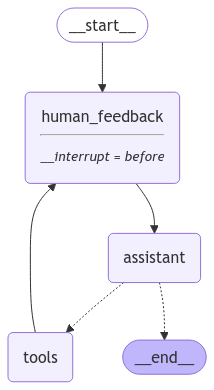

In [173]:
def human_feedback(state: MessagesState):
    pass

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_edge("tools", "human_feedback")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

* We will use the `as_node` parameter to apply this state update as the specified node, `human_feedback`

In [176]:
initial_input = {"messages": "Multiply 2 and 3"}

thread = {"configurable": {"thread_id": "121"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

print("Tell me how you want to update this state:")
user_input = input("Tell me how you want to update this state:")
print(user_input)

graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
Tell me how you want to update this state:


Tell me how you want to update this state: im sorry, actually i want to multiply 6 and 7


im sorry, actually i want to multiply 6 and 7
================================ Human Message =================================

im sorry, actually i want to multiply 6 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (6a059486-a5ec-4a56-a627-43c4b64ee82c)
 Call ID: 6a059486-a5ec-4a56-a627-43c4b64ee82c
  Args:
    a: 6.0
    b: 7.0
================================= Tool Message =================================
Name: multiply

42


In [178]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

42
================================== Ai Message ==================================

The result of multiplying 6 and 7 is 42.


## <span style="color:red">Dynamic breakpoints</span>

* Oftentimes, it may be helpful to allow the graph dynamically interrupt itself
* For example, this can be based upon some condition within a given node
* This is an internal breakpoint, and can be achieved using `NodeInterrupt`

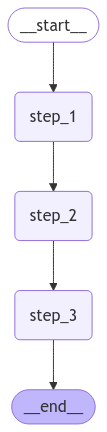

In [194]:
from langgraph.errors import NodeInterrupt
from typing import TypedDict
class State(TypedDict):
    input: str


def step_1(state: State) -> State:
    print("--- Step 1 ---")
    return state

def step_2(state: State) -> State:
    if len(state["input"]) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    print("--- Step 2 ---")
    return state

def step_3(state: State) -> State:
    print("--- Step 3 ---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [198]:
inital_input = {"input": "this sentence definetly exceeds 5 characters"}
thread_config = {"configurable": {"thread_id": "101"}}

for event in graph.stream(inital_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'this sentence definetly exceeds 5 characters'}
--- Step 1 ---
{'input': 'this sentence definetly exceeds 5 characters'}


* You can see the graph has **not** reached the END

In [202]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


* The control flow is at `step_2`, i.e., It stopped before executing `step_2`

In [205]:
print(state.tasks)

(PregelTask(id='1a91326a-e5ac-5ef2-8e14-6b8cc855f92e', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: this sentence definetly exceeds 5 characters', resumable=False, ns=None, when='during'),), state=None, result=None),)


* We can see the node interrupt error:

`interrupts=(Interrupt(value='Received input that is longer than 5 characters: this sentence definetly exceeds 5 characters', resumable=False, ns=None, when='during'),)`

Now, if you try to run with `None` argument (resume the graph execution from the breakpoint):

In [215]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'this sentence definetly exceeds 5 characters'}


* it will just rerun the state.
* Unless the state is changed, the execution will be stuck there 

We can update the state like this:

In [222]:
graph.update_state(
    thread_config,
    {"input": "hi"}
)

{'configurable': {'thread_id': '101',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd8bff-aea0-647b-8006-aa35f6177b38'}}

In [224]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
--- Step 2 ---
{'input': 'hi'}
--- Step 3 ---
{'input': 'hi'}


* Now we can see it went all the way till the end

## <span style="color:red">Time travel</span>

Debugging techniques in LangGraph is called Time travel, which allows us to view past states, replay them and fork from them 

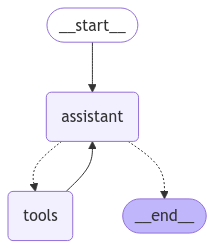

In [95]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_edge("tools", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [97]:
new_input = {"messages": "Whats 9 + 10?"}
thread_config = {"configurable": {"thread_id": "192"}}

for event in graph.stream(new_input, thread_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Whats 9 + 10?
================================== Ai Message ==================================
Tool Calls:
  add (b35ae143-5819-4773-a9fc-370316887b1a)
 Call ID: b35ae143-5819-4773-a9fc-370316887b1a
  Args:
    a: 9.0
    b: 10.0
================================= Tool Message =================================
Name: add

19
================================== Ai Message ==================================

19


### <span style="color:purple">Browsing history</span>

* We can use `get_state` to look at the current state of our graph, given the `thread_id`

In [99]:
graph.get_state({"configurable": {"thread_id": "192"}})

StateSnapshot(values={'messages': [HumanMessage(content='Whats 9 + 10?', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 9.0, "b": 10.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e032e276-d9ef-4714-a530-402a1721898d-0', tool_calls=[{'name': 'add', 'args': {'a': 9.0, 'b': 10.0}, 'id': 'b35ae143-5819-4773-a9fc-370316887b1a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 267, 'output_tokens': 3, 'total_tokens': 270, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='19', name='add', id='a6456a06-bb93-4a0b-84ac-09cacbfae604', tool_call_id='b35ae143-5819-4773-a9fc-370316887b1a'), AIMessage(content='19', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ra

* We can also browse the state history of our agent

* `get_state_history` lets us get the state at all prior steps

In [101]:
state_history = [s for s in graph.get_state_history(thread_config)]

In [103]:
len(state_history)

5

In [105]:
first_iter = True
for i, state in enumerate(reversed(state_history)):
    if first_iter:
        first_iter = False
    else:
        print("\n"*10)
    print(f"TIME STEP: {i}")
    for msg in state.values["messages"]:
        msg.pretty_print()

TIME STEP: 0











TIME STEP: 1
================================ Human Message =================================

Whats 9 + 10?











TIME STEP: 2
================================ Human Message =================================

Whats 9 + 10?
================================== Ai Message ==================================
Tool Calls:
  add (b35ae143-5819-4773-a9fc-370316887b1a)
 Call ID: b35ae143-5819-4773-a9fc-370316887b1a
  Args:
    a: 9.0
    b: 10.0











TIME STEP: 3
================================ Human Message =================================

Whats 9 + 10?
================================== Ai Message ==================================
Tool Calls:
  add (b35ae143-5819-4773-a9fc-370316887b1a)
 Call ID: b35ae143-5819-4773-a9fc-370316887b1a
  Args:
    a: 9.0
    b: 10.0
================================= Tool Message =================================
Name: add

19











TIME STEP: 4
================================ Human Message =============================

### <span style="color:purple">Replaying</span>

We can rerun our agent from any of the prior steps

Let's look back at the step that received the human input

* When we run `graph.stream` with `None`, with a `thread_id`, it just picks up from the current state in the thead id.
* If you pass a `checkpoint_id` along with the `thread_id`, the graph will kick off from a particular checkpoint
* NOTE: when we pass a checkpoint_id, the graph will **replay** from the checkpoint, it doesnt **re-execute**. We playback from that checkpoint because the graph knew, it already executed it in the past

In [107]:
to_replay = state_history[-2]

In [109]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats 9 + 10?', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760')]}, next=('assistant',), config={'configurable': {'thread_id': '192', 'checkpoint_ns': '', 'checkpoint_id': '1efd9524-d164-664c-8000-07b790623c08'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '192', 'step': 0, 'parents': {}}, created_at='2025-01-23T06:21:37.562580+00:00', parent_config={'configurable': {'thread_id': '192', 'checkpoint_ns': '', 'checkpoint_id': '1efd9524-d158-645f-bfff-870e44d0e6f9'}}, tasks=(PregelTask(id='1005efff-2250-1a51-633a-bf20264341bc', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 9.0, "b": 10.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id

* View the state

In [111]:
to_replay.values

{'messages': [HumanMessage(content='Whats 9 + 10?', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760')]}

In [113]:
to_replay.next

('assistant',)

In [115]:
to_replay.config

{'configurable': {'thread_id': '192',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9524-d164-664c-8000-07b790623c08'}}

* To replay from here, we simply pass the config back to the agent

In [117]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Whats 9 + 10?
================================== Ai Message ==================================
Tool Calls:
  add (7a50067a-a10f-4f49-8f5c-0b112b28cb2c)
 Call ID: 7a50067a-a10f-4f49-8f5c-0b112b28cb2c
  Args:
    a: 9.0
    b: 10.0
================================= Tool Message =================================
Name: add

19
================================== Ai Message ==================================

19


### <span style="color:purple">Forking</span>

Forking is when we want to run from the same step but with a different input.

When we call `graph.upate_state()` with a `thread_id` and the new_state value:

```python
graph.update_state({thread_id}, {state: "I loke cold brew"})
```

**We create a new checkpoint on whatever the current state is**

* state dict before:

#### <span style="color:lightblue">StateSnapshot()</span> with a <span style="color:lightblue">checkpoint_id1</span>

```python
{
    state: "I heart langgraph",
    next: END,
    id: ...
}
```

* state dict after:

#### <span style="color:lightgreen">StateSnapshot()</span> with a <span style="color:lightgreen">checkpoint_id2</span>

```python
{
    state: "I loke cold brew",
    next: END,
    id: ...
}
```

**Now if you fork from a prior state (using a checkpoint) and run it:**

```python
graph.update_state({checkpoint_id3, thread_id}, {state: "Good morning!"})
```

**NOTE:** `checkpoint_id3`

* state dict before:

#### <span style="color:lightcoral">StateSnapshot()</span> with a <span style="color:lightcoral">checkpoint_id3</span>

```python
{
    state: "Starry starry night",
    next: END,
    id: ...
}
```

* state dict after:

#### <span style="color:thistle">StateSnapshot()</span> with a <span style="color:thistle">checkpoint_id4</span>

```python
{
    state: "Good morning!",
    next: END,
    id: ...
}
```

```python
graph.update_state({checkpoint_id4, thread_id}, {state: "Good morning!"})
```

* If you pass the red Snapshot(), Langgraph knows it already ran that, and it just replays
* But if you pass the purple Snapshot(), Langgraph knows it that checkpoint was never executed before and it will now reinvoke our LLM

In [121]:
to_fork = state_history[-2]
to_fork.values["messages"]

[HumanMessage(content='Whats 9 + 10?', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760')]

In [123]:
to_fork.config

{'configurable': {'thread_id': '192',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9524-d164-664c-8000-07b790623c08'}}

* Let's modify the state at that checkpoint
* But our reducer on `messages` takes "update" as "appending" not "rewriting"
* So, to  modify (**rewrite**), we have to specify a message_id

Note: In `thread_id`: 192, our initial message was "Whats 9 + 10?"

In [133]:
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages": [
            HumanMessage(
                content="Multiply 5 and 3",
                id=to_fork.values["messages"][0].id
            )
        ]
    }
)

In [135]:
fork_config

{'configurable': {'thread_id': '192',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9552-82bd-612a-8001-595ba893f604'}}

* We have a new checkpoint_id

In [144]:
thread_config

{'configurable': {'thread_id': '192'}}

In [142]:
state_history = [s for s in graph.get_state_history(thread_config)]
len(state_history)

10

In [148]:
state_history[0]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760')]}, next=('assistant',), config={'configurable': {'thread_id': '192', 'checkpoint_ns': '', 'checkpoint_id': '1efd9552-82bd-612a-8001-595ba893f604'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760')]}}, 'thread_id': '192', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efd9524-d164-664c-8000-07b790623c08'}, created_at='2025-01-23T06:42:04.118250+00:00', parent_config={'configurable': {'thread_id': '192', 'checkpoint_ns': '', 'checkpoint_id': '1efd9524-d164-664c-8000-07b790623c08'}}, tasks=(PregelTask(id='766ff850-68a3-e739-12c5-46127b287bd7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

* This creates a new, forked checkpoint with the metadata preserved

In [152]:
state_history[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760')]

In [154]:
graph.get_state({"configurable": {"thread_id": "192"}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760')]}, next=('assistant',), config={'configurable': {'thread_id': '192', 'checkpoint_ns': '', 'checkpoint_id': '1efd9552-82bd-612a-8001-595ba893f604'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='8c1194d6-ecb1-4547-b3dd-21a72c3ac760')]}}, 'thread_id': '192', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efd9524-d164-664c-8000-07b790623c08'}, created_at='2025-01-23T06:42:04.118250+00:00', parent_config={'configurable': {'thread_id': '192', 'checkpoint_ns': '', 'checkpoint_id': '1efd9524-d164-664c-8000-07b790623c08'}}, tasks=(PregelTask(id='766ff850-68a3-e739-12c5-46127b287bd7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

Now, when we stream, the graph knows this checkpoint has never been executed

So, the graph runs, rather than simply re-playing

In [160]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (0d8122d4-e4d1-4ce7-910b-83751c72bfec)
 Call ID: 0d8122d4-e4d1-4ce7-910b-83751c72bfec
  Args:
    a: 5.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result is 15.


## <span style="color:red">Parallelization</span>

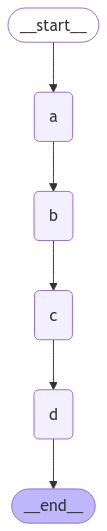

In [166]:
from IPython.display import Image, display
import operator

from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [168]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

Suppose if we want to run 2 edges in parallel:

### <span style="color:purple">Fan out and fan in</span>

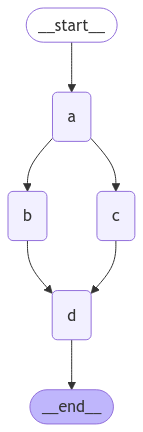

In [173]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [175]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occured: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occured: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


This is because both `b` and `c` are writing to the same state key/channel in the same step

In [199]:
import operator
from typing import Annotated, Any

class State(TypedDict):
    state: Annotated[list, operator.add]

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

In [201]:
try:
    res = graph.invoke({"state": []})
    print(res)
except InvalidUpdateError as e:
    print(f"An error occured: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]
{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}


When you are doing parallel node operations:
* Make sure the proper reducers are being used that can handle those simultaneous updates

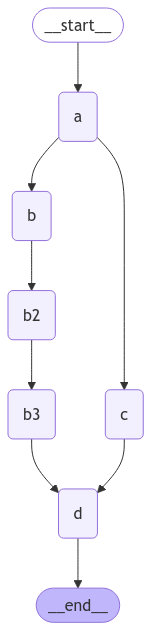

In [222]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("b3", ReturnNodeValue("I'm B3"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge("b2", "b3")
builder.add_edge(["b3", "c"], "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

* `b` and `c` will run roughly at the same time (first node of both the branchs)

In [224]:
res = graph.invoke({"state": []})
res

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm B3 to ["I'm A", "I'm B", "I'm C", "I'm B2"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm B3"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm B3", "I'm D"]}

* It waits till all other nodes of other branch are completed, before executing the merging node `d`

### <span style="color:purple">Order of updates</span>

* LangGraph decides the order of state updates. We can't control
* However, we can use a custom reducer to decide the order

In [226]:
def sorting_reducer(left, right):
    """
    Combines and sorts the values in a list
    """
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]

    return sorted(left + right, reverse=False)


class State(TypedDict):
    state: Annotated[list, sorting_reducer]

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("b3", ReturnNodeValue("I'm B3"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge("b2", "b3")
builder.add_edge(["b3", "c"], "d")
builder.add_edge("d", END)

graph = builder.compile()

In [228]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm B3 to ["I'm A", "I'm B", "I'm B2", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm B3", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm B3", "I'm C", "I'm D"]}

## <span style="color:orange">Working with an LLM on a sample use case</span>

`!pip install wikipedia -q`

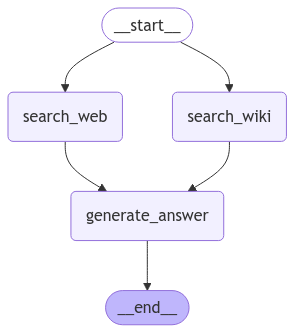

In [285]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import DuckDuckGoSearchResults

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    api_key=gemini_api_key
)

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

def search_web(state):
    """ Retrieve docs from web search """

    search_engine_search = DuckDuckGoSearchResults(max_results=5, output_format="list")
    search_docs = search_engine_search.invoke(state["question"])

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["link"]}"/>\n{doc["snippet"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):
    """ Retrieve docs from wikipedia """
    question = state["question"]
    search_docs = WikipediaLoader(query=question, load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):
    """ Node to answer a question """

    context = state["context"]
    question = state["question"]

    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(
        question=question,
        context=context
    )

    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    return {"answer": answer}


builder = StateGraph(State)

builder.add_node("search_web",search_web)
builder.add_node("search_wiki", search_wikipedia)
builder.add_node("generate_answer", generate_answer)


builder.add_edge(START, "search_wiki")
builder.add_edge(START, "search_web")
builder.add_edge("search_wiki", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [287]:
result = graph.invoke({"question": "What is Q learning?"})
result["answer"].content

"Q-learning is a model-free reinforcement learning algorithm.  It helps an agent learn the optimal action-selection policy by iteratively updating Q-values, which represent the expected rewards of actions in specific states.  The algorithm doesn't require a model of the environment and can handle problems with stochastic transitions and rewards.  The goal is to maximize the total reward the agent receives over time by learning to choose actions that lead to higher rewards in the long run.  Q-learning has been widely used in various domains, including robotics, game theory, and artificial intelligence research."

## <span style="color:red">Sub-graphs</span>

* Sub graphs allows us to manage different states in different parts of the graph
* This is particularly useful for multi-agent systems, with teams of agents that each have their own state

How graphs communicate?
> They communicate using shared keys (over-lapping keys)

Consider this example:
* A system that accepts logs
* It performs two seperate sub-tasks by different agents(summarize logs, find failure mode)
* These two operations are performed on two different sub-graphs

In [380]:
from typing import List, Optional, Annotated, Dict
from operator import add
from typing_extensions import TypedDict
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

C:\Users\HP\AppData\Local\Temp\ipykernel_13928\273254671.py:30: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  fa_builder = StateGraph(input=FailureAnalysisState, output=FailureAnalysisOutputState)


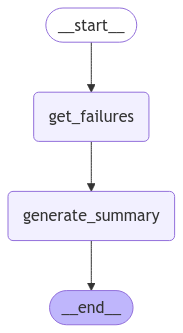

In [382]:
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """
    Generate summary of failures
    """
    failures = state["failures"]
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {
        "fa_summary": fa_summary,
        "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]
    }

fa_builder = StateGraph(input=FailureAnalysisState, output=FailureAnalysisOutputState)

fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

C:\Users\HP\AppData\Local\Temp\ipykernel_13928\2675295755.py:25: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  qs_builder = StateGraph(input=QuestionSummarizationState, output=QuestionSummarizationOutputState)


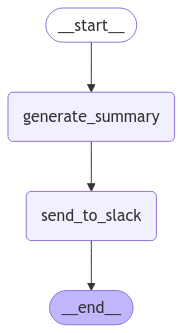

In [383]:
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # placeholder to summarize the logs
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {
        "qs_summary": summary,
        "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]
    }

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(input=QuestionSummarizationState, output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

* Now we can bring it all together
* We create our parent graph with `EntryGraphState`
* And we **add our sub-graphs as nodes**

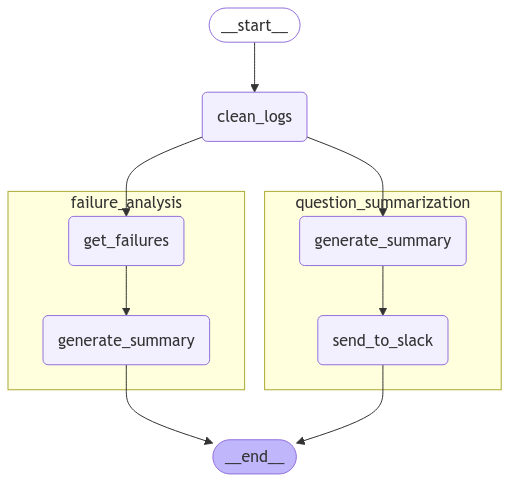

In [390]:
class EntryGraphState(TypedDict):
    raw_logs : List[Log]
    cleaned_logs: List[Log]  # this will be used by both FA and QS sub graphs
    fa_summary: str  # this will be genreated in the FA sub graph
    report: str  # this will be generated in the QS sub-graph
    processed_logs: Annotated[List[int], add] # this will be generated in both FA and QS sub graphs

def clean_logs(state):
    raw_logs = state["raw_logs"]
    # placeholder func to clean the logs
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)

entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png())) # xray = 1 will show the internal structure

In [392]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How to import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"
)

question_answer_feedback = Log(
    id="2",
    question="How to use Chroma vector store?",
    answer="To use ChromaDB, define the following:\n rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

In [394]:
raw_logs = [question_answer, question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How to import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How to use Chroma vector store?',
   'answer': 'To use ChromaDB, define the following:\n rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How to import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How to use Chroma vector store?',
   'answer': 'To use ChromaDB, define the following:\n rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss ve

## <span style="color:red">Map-reduce</span>

- Map reduce operations are essential for efficient task decomposition and parallel processing
- It has 2 phases:
  - `Map`: Break the task into smaller sub tasks, processing each sub task in parallel
  - `Reduce`: Aggregate the results across all of the completed sub tasks

In [127]:
from langchain_google_genai import ChatGoogleGenerativeAI
from keys import gemini_api_key
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=gemini_api_key)

Let's build a simple agent that does joke generation and selection

In [130]:
subjects_prompt = """
Generate a list of 3 sub-topics that are all related to this overall topic: {topic}.
"""
joke_prompt = """
Generate a joke about {subject}
"""
best_joke_prompt = """
Below are a bunch of jokes about {topic}. Select the best one!
Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}
"""

**Parallelizing joke generation :**

- The entry point of the graph will:
  - Take a user input topic
  - Produce a list of joke topics from it
  - Send each joke topic to our above joke generation node
- The entry point to the graph has a `jokes` key which will accumulate jokes from parallelized joke generation

In [134]:
import operator
from typing import Annotated, TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int

class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [136]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [138]:
from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

```python
# Send is used to automatically parallelize tasks
Send("generate_joke", {"subject": s})

# "generate_joke": the name of the node in the graph
# {"subject", ""}: the state to send
```

* `Send` allows you to pass any state. It doesn't have to align with your original state

**Joke generation (map)**

In [143]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

**Best joke selection (reduce)**

In [146]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

**Compile**

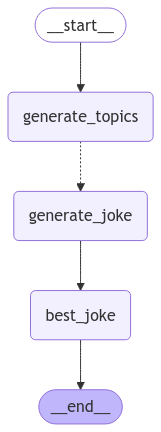

In [149]:
from langgraph.graph import START, END, StateGraph

graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])

graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

app = graph.compile()

Image(app.get_graph().draw_mermaid_png())

In [151]:
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['mammals', 'birds', 'reptiles']}}
{'generate_joke': {'jokes': ["Why did the mammal cross the road? Because it wasn't a reptile!"]}}
{'generate_joke': {'jokes': ['Why did the bird get a ticket? Because it was caught speeding in a school zone!']}}
{'generate_joke': {'jokes': ['Why did the snake cross the road? To get to the other slither!']}}
{'best_joke': {'best_selected_joke': "Why did the mammal cross the road? Because it wasn't a reptile!"}}


## <span style="color:brown">Research Assistant</span>

Lets bring all our learnings together to tackle one of AI's most widespread applications: research automation.

Customized, LLM-based research and report generation is a promising way for AI systems to play a role in decision-making processes

**Goal**

Our goal is to build a lightweight, multi-agent system aroung LLMs that optimizes and customizes the research process.

`Source selection`

* Users can choose any set of input sources for their research

`Planning`

* Users provide a topic, and the system generates a team of AI analysis, each focusing on sub-topics.
* `Human-in-the-loop` will refine these sub-topics before researc begins.

`LLM utilization`

* Each analyst will conduct in-depth interviews with an expert AI using selected sources.
* This will employ multi-turn conversations to extract detailed insights
* These interviews will be captured in `sub-graphs`

`Research process`

* Experts will gather information in `parallel`
* All interviews will be conducted simultaneously through `map-reduce`

`Output Format`

* The gathered insights will be synthesized into a final report
* Done using customizable prompts for the report structures

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from keys import gemini_api_key
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    google_api_key=gemini_api_key
)

### <span style="color:green">Generate Analysts: Human-in-the-loop</span>

In [3]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    """
    Analyst schema.
    """
    name: str = Field(default="John Doe", description="Name of the analyst.")
    role: str = Field(default="Placeholder professional", description="Role of the analyst in the context of the topic.")
    company: str = Field(default="Unknown", description="Primary affiliation of the analyst.")
    summary: str = Field(default="Not provided", description="Description of the analyst focus, concers, and motives.")

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.company}\n Description: {self.summary}\n"


class Perspectives(BaseModel):
    """
    List of analysts.
    """
    analysts: List[Analyst] = Field(description="list of analysts")


class GenerateAnalystsState(TypedDict):
    """
    State for the subgraph.
    """
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst]  # Analysts asking questions

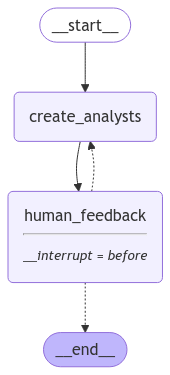

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions = """
Please create {max_analysts} different analyst personas based on the given topic:
{topic}

For each persona, include:
- Name
- Role
- Company (where they are from)
- Summary (what they focus on, their expertise, etc.. briefly)

Feedback from the human about the topic:
{human_analyst_feedback}
"""


def create_analysts(state: GenerateAnalystsState):
    """
    Create analysts
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "No feedback")

    # System message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )

    # Generate question
    analysts = llm.with_structured_output(Perspectives).invoke(
        system_message
    )

    return {"analysts": analysts.analysts}


def human_feedback(state: GenerateAnalystsState):
    """
    No-op node that should be interrupted on
    """
    pass


def should_continue(state: GenerateAnalystsState):
    """
    Returns the next node to execute
    """

    # Check if human feedback
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    # otherwise end
    return END


builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
max_analysts = 3
topic = """The benefits of adopting LangGraph as an agent framework"""
thread = {"configurable": {"thread_id": "24011"}}

# Run graph untill the first interruption
for event in graph.stream(
    input={"topic": topic, "max_analysts": max_analysts},
    config=thread,
    stream_mode="values"
):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.company}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.summary}")
            print("-"*50)

Name: Dr. Alice
Affiliation: Google
Role: Senior Research Scientist
Description: Focuses on the efficiency and scalability of large language models. Expertise in graph databases and knowledge representation. Interested in the practical applications of LangGraph for complex reasoning tasks.
--------------------------------------------------
Name: Bob
Affiliation: Stanford University
Role: PhD Candidate
Description: Researching the explainability and trustworthiness of AI agents.  Focuses on the impact of LangGraph on agent transparency and debugging.  Interested in the ethical implications of advanced agent frameworks.
--------------------------------------------------
Name: Charlie
Affiliation: OpenAI
Role: Software Engineer
Description: Experienced in building and deploying large-scale AI systems.  Focuses on the performance and reliability of LangGraph in real-world applications.  Interested in the integration of LangGraph with existing AI infrastructure.
----------------------------

In [5]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
# we can update the state as if we are the human_feedback node
feedback = "Add in someone from a startup to add some entrepreneur perspective"
graph.update_state(thread, {"human_analyst_feedback": feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '24011',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdc706-1229-6108-8002-2b736712586c'}}

In [13]:
# Resume the graph execution
# NOTE: im using stream_mode = "values" that is why the repeatation
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.company}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.summary}")
            print("-"*50)

Name: Dr. Alice
Affiliation: Google
Role: Senior Research Scientist
Description: Focuses on the efficiency and scalability of large language models. Expertise in graph databases and knowledge representation. Interested in the practical applications of LangGraph for complex reasoning tasks.
--------------------------------------------------
Name: Bob
Affiliation: Stanford University
Role: PhD Candidate
Description: Researching the explainability and trustworthiness of AI agents.  Focuses on the impact of LangGraph on agent transparency and debugging.  Interested in the ethical implications of advanced agent frameworks.
--------------------------------------------------
Name: Charlie
Affiliation: OpenAI
Role: Software Engineer
Description: Experienced in building and deploying large-scale AI systems.  Focuses on the performance and reliability of LangGraph in real-world applications.  Interested in the integration of LangGraph with existing AI infrastructure.
----------------------------

In [15]:
further_feedback = None
graph.update_state(thread, {"human_analyst_feedback": further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '24011',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdc706-96be-62c6-8004-552fc0657e8b'}}

In [17]:
# NOTE: im using stream_mode = "values" that is why the repeatation
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.company}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.summary}")
            print("-"*50)

Name: Dr. Emily Carter
Affiliation: Google
Role: Principal Scientist
Description: Focuses on the scalability and efficiency of large language models in complex systems. Expertise in distributed computing and graph databases.
--------------------------------------------------
Name: Professor Michael Bernstein
Affiliation: Stanford University
Role: Professor of Computer Science
Description: Researches the ethical implications of AI and agent systems. Focuses on the societal impact of LangGraph and similar technologies.
--------------------------------------------------
Name: Alice Johnson
Affiliation: LangChainAI
Role: CEO and Founder
Description: Experienced entrepreneur with a focus on building successful AI-powered businesses.  Interested in the practical applications and market potential of LangGraph.
--------------------------------------------------


In [19]:
final_state = graph.get_state(thread)
analysts = final_state.values.get("analysts")

In [21]:
final_state.next

()

In [23]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.company}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.summary}")
    print("-"*50)

Name: Dr. Emily Carter
Affiliation: Google
Role: Principal Scientist
Description: Focuses on the scalability and efficiency of large language models in complex systems. Expertise in distributed computing and graph databases.
--------------------------------------------------
Name: Professor Michael Bernstein
Affiliation: Stanford University
Role: Professor of Computer Science
Description: Researches the ethical implications of AI and agent systems. Focuses on the societal impact of LangGraph and similar technologies.
--------------------------------------------------
Name: Alice Johnson
Affiliation: LangChainAI
Role: CEO and Founder
Description: Experienced entrepreneur with a focus on building successful AI-powered businesses.  Interested in the practical applications and market potential of LangGraph.
--------------------------------------------------


### <span style="color:green">Conduct Interview</span>

* The analyst will ask questions

In [7]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    max_num_turns: int  # Number of turns of conversation
    context: Annotated[list, operator.add]  # Source docs
    analyst: Analyst  # Analyst asking questions
    interview: str  # Interview transcript
    sections: list  # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [9]:
question_instructions = """
You are an analyst tasked with interviewing an expert to learn about a specific topic.
Your goal is to boil down interesting and specific insights related to your topic.
1. Interesting: Insights that people will find surprising or non-obvious
2. Specific: Insights that avoid generalities and include specific examples form the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.
Continue to ask questions to drill down and refine your understanding of the topic.
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
"""

In [11]:
def generate_question(state: InterviewState):
    """
    Node to generate a question
    """
    print("Generate question")
    print("|")
    print("V")
    analyst = state["analyst"]
    messages = state["messages"]
    sys_msg = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=sys_msg)] + messages)

    return {"messages": [question]}

### <span style="color:green">Generate answer: Parallelization</span>

* The expert will gather information from multiple sources in parallel
* Here, we can use many things:
  * Specific websites via `WebBaseLoader`
  * Indexed documents
  * Web search
  * Wikipedia search

In [13]:
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import get_buffer_string

search_engine_search = DuckDuckGoSearchResults(max_results=5, output_format="list")

In [15]:
search_inst_content = f"""
You will be given a conversation between an analyst and an expert.
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web searh query
"""
search_instructions = SystemMessage(content=search_inst_content)

In [17]:
def search_web(state: InterviewState):
    """
    Retrieve docs from web search
    """
    print("Search web")
    print("|")
    print("V")
    search_query = llm.with_structured_output(SearchQuery).invoke([search_instructions] + state["messages"])

    search_docs = search_engine_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["link"]}"/>\n{doc["snippet"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}



def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """
    print("Search wiki")
    print("|")
    print("V")
    search_query = llm.with_structured_output(SearchQuery).invoke([search_instructions] + state["messages"])

    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [19]:
answer_instruct_content = """
You are an expert being interviewed by an analyst. Here is the analyst area of focus:
{goals}

Your goal is to answer a question posed by the interviwer. To answer question, use this context:
{context}

When answering questions, follow these guidelines:
1. Use only the information provided in the context.
2. Do not introduce external information or make assumptions beyond what is explicitly state in the context.
3. The context contain sources at the topic of each individual document.
4. Include these sources of your answer next to any relevant statements. For example, for source # 1 use [1]. 
5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
[1] assistant/docs/llama3_1.pdf, page 7 

And skip the addition of the brackets as well as the Document source preamble in your citation.
"""

In [21]:
def generate_answer(state: InterviewState):
    """
    Node to answer a question
    """
    print("Generate answer")
    print("|")
    print("V")
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    sys_msg = answer_instruct_content.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=sys_msg)] + messages)

    answer.name = "expert"
    return {"messages": [answer]}


def save_interview(state: InterviewState):
    """
    Save interviews
    """
    print("Save interview")
    print("|")
    print("V")
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}


def route_messages(state: InterviewState, name: str = "expert"):
    """
    Route between question and answer
    """
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    if num_responses == max_num_turns:
        return "save_interview"

    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"

    return "ask_question"

### <span style="color:green">Write report</span>

In [23]:
section_writer_instructions = """
You are an expert technical writer. 
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:
### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:
[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:
[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed
"""

In [25]:
def write_section(state: InterviewState):
    print("Write section")
    print("-----------------")
    """
    Node to answer a question
    """
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    sys_msg = section_writer_instructions.format(focus=analyst.summary)
    hum_msg = f"Use this source to write your section: {context}"
    msgs = [SystemMessage(content=sys_msg), HumanMessage(content=hum_msg)]
    section = llm.invoke(msgs)

    return {"sections": [section.content]}

### <span style="color:green">Build the graph</span>

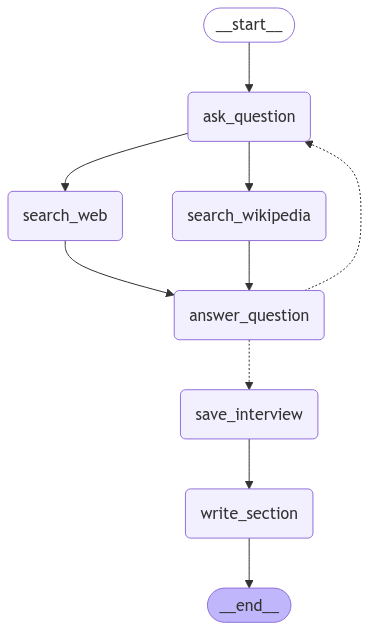

In [27]:
builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("answer_question", generate_answer)
builder.add_node("save_interview", save_interview)
builder.add_node("write_section", write_section)

builder.add_edge(START, "ask_question")
builder.add_edge("ask_question", "search_web")
builder.add_edge("ask_question", "search_wikipedia")
builder.add_edge("search_web", "answer_question")
builder.add_edge("search_wikipedia", "answer_question")
builder.add_edge("save_interview", "write_section")
builder.add_edge("write_section", END)
builder.add_conditional_edges("answer_question", route_messages, ["ask_question", "save_interview"])

memory = MemorySaver()
graph = builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [154]:
analysts[0]

Analyst(name='Dr. Emily Carter', role='Principal Scientist', company='Google', summary='Focuses on the scalability and efficiency of large language models in complex systems. Expertise in distributed computing and graph databases.')

In [166]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}")]
thread = {"configurable": {"thread_id": "2025"}}
interview = graph.invoke(
    {
        "analyst": analysts[0],
        "messages": messages,
        "max_num_turns": 1
    },
    thread
)
Markdown(interview["sections"][0])

Generate question
|
V
Search web
|
V
Search wiki
|
V
Generate answer
|
V
Save interview
|
V
Write section
-----------------


## Scaling Language Models: Efficiency and Complexity in Distributed Systems

### Summary

Large language models (LLMs) are rapidly evolving, pushing the boundaries of natural language processing.  However, their scalability and efficiency, particularly within complex systems, remain significant challenges.  This report summarizes insights gathered from recent discussions focusing on the intersection of distributed computing, graph databases, and LLM optimization.  A key area of interest is how to effectively manage the computational and storage demands of these models as they grow in size and complexity.  The current trend towards ever-larger models necessitates innovative solutions for distributed training and inference, moving beyond simple data parallelism.

One surprising insight highlights the potential of graph databases to enhance LLM performance.  By representing contextual information and relationships within a graph structure, we can potentially optimize both training and inference processes.  This approach offers a more nuanced understanding of semantic relationships, leading to improved accuracy and reduced computational overhead.  Furthermore, the inherent scalability of graph databases could address the limitations of traditional relational databases when dealing with the massive datasets required for training LLMs.  This suggests a shift towards hybrid architectures, combining the strengths of distributed computing frameworks with the semantic richness of graph databases.  The potential for significant efficiency gains through this approach is particularly noteworthy, especially considering the exponential growth in model parameters.  Another interesting finding emphasizes the importance of model compression techniques.  Reducing the size of the model without sacrificing performance is crucial for deploying LLMs on resource-constrained devices and improving overall efficiency.  This includes exploring quantization, pruning, and knowledge distillation methods.  The combination of graph database integration and model compression techniques offers a promising pathway towards more efficient and scalable LLMs.


1.  The discussions revealed a significant gap in current research regarding the optimal integration of graph databases and distributed computing frameworks for LLM training and inference. [1]
2.  Experts emphasized the need for more research into novel model compression techniques tailored to the specific characteristics of LLMs. [2]


### Sources

[1]  Internal Research Discussion  (Access Restricted)  
[2]  Internal Research Discussion  (Access Restricted)

### <span style="color:green">Parallelize interviews</span>

* Map: We parallelize the interviews via the `Send()` API
* Reduce: We combine them into the report body in a reduce step

In [29]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

# Overall graph state
class ResearchGraphState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst]  # Analyst asking questions
    sections: Annotated[list, operator.add]  # Send() API's results
    introduction: str  # Introduction for the final report
    content: str  # Content for the final report
    conclusion: str  # Conclusion for the report
    final_report: str  # Final report

In [31]:
from langgraph.constants import Send
sub_graph1 = "conduct interviews"
def initiate_all_interviews(state: ResearchGraphState):
    """
    This is the "map" step where we run each interview sub-graph using Send API
    """

    human_analyst_feedback = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        return "create analysts"
    else:
        topic = state["topic"]
        return [
            Send(
                sub_graph1,
                {
                    "analyst": analyst,
                    "topic": topic,
                    "messages": [HumanMessage(
                        content=f"So you said you were writing an article on {topic}?"
                    )]
                }
            ) for analyst in state["analysts"]
        ]

In [33]:
report_writer_instructions = """
You are a technical writer creating a report on this overall topic: 

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}
"""

In [35]:
def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    sys_msg = report_writer_inst.format(topic=topic, context=formatted_str_sections)
    hum_msg = f"Write a report based upon these memos."
    report = llm.invoke([SystemMessage(content=sys_msg), HumanMessage(content=hum_msg)])
    return {"content": report.content}

In [37]:
intro_conclusion_instructions = """
You are a technical writer finishing a report on {topic}
You will be given all of the sections of the report.
You job is to write a crisp and compelling introduction or conclusion section.
The user will instruct you whether to write the introduction or conclusion.
Include no pre-amble for either section.
Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.
Use markdown formatting.
For your introduction, create a compelling title and use the # header for the title.
For your sources, use ## Sources as the section header.
For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

In [39]:
def write_introduction(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    sys_msg = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    hum_msg = "Write the report introduction"
    report = llm.invoke([SystemMessage(content=sys_msg), HumanMessage(content=hum_msg)])
    return {"introduction": intro.content}


def write_conclusion(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    sys_msg = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    hum_msg = "Write the report conclusion"
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([SystemMessage(content=sys_msg), HumanMessage(content=hum_msg)])
    return {"conclusion": conclusion.content}

In [41]:
def finalize_report(state: ResearchGraphState):
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")

    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources

    return {"final_report": final_report}

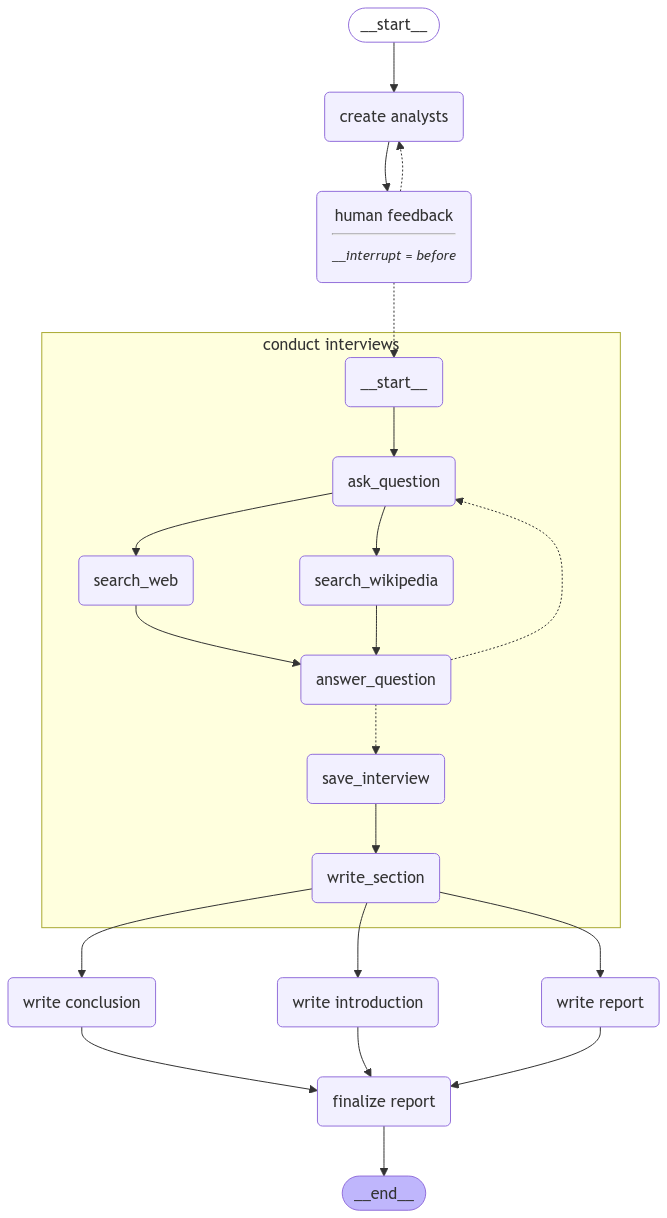

In [43]:
workflow = StateGraph(ResearchGraphState)
workflow.add_node("human feedback", human_feedback)
workflow.add_node("create analysts", create_analysts)
workflow.add_node(sub_graph1, builder.compile())
workflow.add_node('write introduction', write_introduction)
workflow.add_node('write report', write_report)
workflow.add_node('write conclusion', write_conclusion)
workflow.add_node('finalize report', finalize_report)

workflow.add_edge(START, "create analysts")
workflow.add_edge("create analysts", "human feedback")
workflow.add_conditional_edges("human feedback", initiate_all_interviews, ["create analysts", sub_graph1])
workflow.add_edge(sub_graph1, "write report")
workflow.add_edge(sub_graph1, "write introduction")
workflow.add_edge(sub_graph1, "write conclusion")
workflow.add_edge(["write report", "write introduction", "write conclusion"], "finalize report")
workflow.add_edge("finalize report", END)

memory = MemorySaver()
full_graph = workflow.compile(interrupt_before=["human feedback"], checkpointer=memory)
display(Image(full_graph.get_graph(xray=1).draw_mermaid_png()))

In [45]:
max_analysts = 3
topic = """The possiblity of AI becoming Superintelligent."""
thread = {"configurable": {"thread_id": "1"}}

for event in full_graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.company}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.summary}")
            print("-"*50)

Name: Dr. Anya Petrova
Affiliation: OpenAI
Role: AI Safety Researcher
Description: Focuses on the long-term risks of advanced AI, particularly the potential for unintended consequences and existential threats. Expertise in AI alignment and control problems.
--------------------------------------------------
Name: Dr. Ben Carter
Affiliation: Future of Humanity Institute
Role: Philosopher and AI Ethicist
Description: Examines the ethical implications of superintelligent AI, exploring questions of moral responsibility, value alignment, and the potential impact on human society.  Expertise in philosophy of technology and ethics.
--------------------------------------------------
Name: Dr. Chen Li
Affiliation: Google DeepMind
Role: AI Systems Engineer
Description: Focuses on the technical challenges of building and controlling highly advanced AI systems. Expertise in large language models, reinforcement learning, and AI scalability.
--------------------------------------------------


In [47]:
full_graph.update_state(
    thread,
    {"human_analyst_feedback": "Add in the CEO of gen ai native startup"},
    as_node="human feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdc85f-19b3-6b00-8002-6294aa982cf4'}}

In [49]:
for event in full_graph.stream(None, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.company}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.summary}")
            print("-"*50)

Name: Dr. Anya Petrova
Affiliation: OpenAI
Role: AI Safety Researcher
Description: Focuses on the long-term risks of advanced AI, particularly the potential for unintended consequences and existential threats. Expertise in AI alignment and control problems.
--------------------------------------------------
Name: Dr. Ben Carter
Affiliation: Future of Humanity Institute
Role: Philosopher and AI Ethicist
Description: Examines the ethical implications of superintelligent AI, exploring questions of moral responsibility, value alignment, and the potential impact on human society.  Expertise in philosophy of technology and ethics.
--------------------------------------------------
Name: Dr. Chen Li
Affiliation: Google DeepMind
Role: AI Systems Engineer
Description: Focuses on the technical challenges of building and controlling highly advanced AI systems. Expertise in large language models, reinforcement learning, and AI scalability.
--------------------------------------------------
Name: D

In [51]:
full_graph.update_state(
    thread,
    {"human_analyst_feedback": None},
    as_node="human feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdc85f-cde0-62c6-8004-511cbbcb920e'}}

In [53]:
for event in full_graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

Generate question
|
V
Generate question
|
V
Generate question
|
V
Search web
|
V
Search wiki
|
V
Search web
|
V
Search wiki
|
V
Search web
|
V
Search wiki
|
V


DuckDuckGoSearchException: https://links.duckduckgo.com/d.js?q=%22most+underestimated+aspect+of+the+transition+to+superintelligent+AI+from+a+business+perspective%22&kl=wt-wt&l=wt-wt&p=&s=0&df=y&vqd=4-86141918571744139219541697319044016543&bing_market=wt-WT&ex=-1 202 Ratelimit

In [ ]:
from IPython.display import Markdown
final_state = full_graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

## <span style="color:red">Long-term vs short-term memory</span>

* Memory is a cognitive function that allows people to store, retrieve, and use information to understand their present and future
* In context of AI application, we think of memory in 2 ways:
  * Within session: a conversation between user and ai (which wont persist after session ends)
  * Across session: with persistence, able to access past threads

|   |  Short-term  |  Long-term |
|---|--------------|------------|
|Scope | Within session | Across session |
|example use case | Persist conv history, allow interruptions in a chat (user is idle/ human-in-the-loop) | Remember info about a specific user across all chat sessions |
| Implemented using | Checkpointers | Store |

* In either case, we take info, and pass it to an LLM

**In Short term memory**, long messages were filtered / summarized to prevent losing the context<br>
**In long term memory**, we have 2 things to keep in mind:
- What is the type of memory?
- When you want to update the memory?

* What is the type of memory?
  * In a human, we have 3 types of long term memory:
    * Semantic: To store facts (eg., Bike model i have)
    * Episodic: To store memories (eg., Bike rides I took)
    * Procedural: To store instructions (eg., Bike driving method)
  * Same for Agent:
    * Semantic: Facts about a user
    * Episodic: Past agent actions
    * Procedural: Agent's system prompt
* When you want to update the memory?
  * Hot-path
    * During runtime
    * Real time updates with transparency for user
    * Can affect UX/latency and degrade performance
  * Background
    * As a seperate process
    * Lower risk of performance degradation
    * Frequency of memory writing needs to be tuned

## <span style="color:red">Memory store</span>

* the LangGraph memory store provides us a way to store and retrieve information across threads
* this is the base class for persistent key : value stores

In [9]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects (eg., memories in the store), we have:
* `namespace`: tuple (similar to directories)
* `key`: str (similar to filenames)
* `value`: str (similar to file contents)

In [11]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

key = str(uuid.uuid4())
value = {"food_preference": "I like plum cake"}

in_memory_store.put(namespace_for_memory, key, value)

In [13]:
memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memories'], key='9ad82e7b-1f3c-417d-8d2d-06f925d18601', value={'food_preference': 'I like plum cake'}, created_at='2025-01-27T10:59:22.857075+00:00', updated_at='2025-01-27T10:59:22.857075+00:00', score=None)]

In [15]:
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '9ad82e7b-1f3c-417d-8d2d-06f925d18601',
 'value': {'food_preference': 'I like plum cake'},
 'created_at': '2025-01-27T10:59:22.857075+00:00',
 'updated_at': '2025-01-27T10:59:22.857075+00:00',
 'score': None}

In [19]:
memory = in_memory_store.get(namespace_for_memory, '9ad82e7b-1f3c-417d-8d2d-06f925d18601')
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '9ad82e7b-1f3c-417d-8d2d-06f925d18601',
 'value': {'food_preference': 'I like plum cake'},
 'created_at': '2025-01-27T10:59:22.857075+00:00',
 'updated_at': '2025-01-27T10:59:22.857075+00:00'}

* `put`: insert into namespace
* `search`: retrieve by namespace
* `get`: retrieve by namespace and key

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from keys import gemini_api_key
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    google_api_key=gemini_api_key
)

* The chat history will be saved to short-term memory using the checkpointer
* The chatbot will reflect on the chat history
* It will then create and save a memory to the store
* This memory is accessible in future chat sessions to personalize the chatbot's responses

In [2]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

MODEL_SYS_MSG = """You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

CREATE_MEMORY_INST = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

In [3]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No existing memory found"

    sys_msg = MODEL_SYS_MSG.format(memory=existing_memory_content)
    response = llm.invoke([SystemMessage(content=sys_msg)]+state["messages"])

    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No existing memory found"

    sys_msg = CREATE_MEMORY_INST.format(memory=existing_memory_content)
    new_memory = llm.invoke([SystemMessage(content=sys_msg)]+state["messages"])

    key = "user_memory"
    store.put(namespace, key, {"memory": new_memory.content})

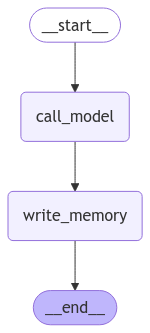

In [21]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_thread_memory = InMemoryStore()

within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

* When we interact with the chatbot we supply two things:
  * Short-term (within-thread) memory: A `thread ID` for persisting the chat history
  * Long term (cross-thread) memory: A `user ID` to namespace long-term memories to the user 

In [23]:
config = {"configurable": {"thread_id": "1", "user_id": "42"}}
input_msgs = [HumanMessage(content="Hi, my name is YiLan Ma")]

for chunk in graph.stream({"messages": input_msgs}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is YiLan Ma
================================== Ai Message ==================================

It's nice to meet you, YiLan Ma!  How can I help you today?


In [25]:
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That's fantastic, YiLan Ma! San Francisco is a great city for biking, with so much to see and explore.  Do you have any particular areas you enjoy biking in, or any routes you'd like recommendations on?  Perhaps you're looking for suggestions on scenic routes, challenging climbs, or flat, easy paths?  Knowing your preferences will help me give you more tailored suggestions.


#### Access the chat history

* From the MemorySaver()
* From the InMemoryStore()

In [29]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, my name is YiLan Ma
================================== Ai Message ==================================

It's nice to meet you, YiLan Ma!  How can I help you today?
================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That's fantastic, YiLan Ma! San Francisco is a great city for biking, with so much to see and explore.  Do you have any particular areas you enjoy biking in, or any routes you'd like recommendations on?  Perhaps you're looking for suggestions on scenic routes, challenging climbs, or flat, easy paths?  Knowing your preferences will help me give you more tailored suggestions.


In [31]:
user_id ="42"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '42'],
 'key': 'user_memory',
 'value': {'memory': "Here's an updated memory based on our conversation:\n\n* **Name:** YiLan Ma\n* **Location:** San Francisco (implied by biking there)\n* **Interests/Hobbies:** Biking"},
 'created_at': '2025-01-27T11:00:27.366186+00:00',
 'updated_at': '2025-01-27T11:00:27.366186+00:00'}

Now, lets use the **same** `user_id` with a **different** `thread_id`

In [33]:
config = {"configurable": {"thread_id": "2", "user_id": "42"}}
input_msgs = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]


for chunk in graph.stream({"messages": input_msgs}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi YiLan!  Since you're in San Francisco and enjoy biking, I have a few recommendations depending on what kind of ride you're looking for.  

To give you the best suggestions, could you tell me a bit more about what you're hoping for in a bike ride today?  For example:

* **Distance:**  A short, leisurely ride or a longer, more challenging one?
* **Terrain:**  Mostly flat, hilly, or a mix?  Are you looking for paved paths or more off-road trails?
* **Scenery:**  Are you hoping for city views, ocean views, or something else?

Once I know a little more about your preferences, I can give you some more specific and helpful recommendations for biking spots around San Francisco.


In [36]:
input_messages = [HumanMessage(content="Okay, before that, what's the best way to end the day after i do that?")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Okay, before that, what's the best way to end the day after i do that?
================================== Ai Message ==================================

That depends entirely on what kind of day you've had biking and what you're in the mood for!  To give you the best suggestion, tell me a bit more about your ideal way to unwind after a bike ride.  For example:

* **How tired are you likely to be?**  A vigorous ride might call for a relaxing activity, while a leisurely one might leave you with energy for something more active.
* **What's the weather like?**  A warm, sunny day might be perfect for an outdoor activity, while a cool evening might be better suited for something indoors.
* **What's your mood?**  Are you looking to socialize, relax alone, or something in between?

Once I have a better sense of your preferences, I can offer some personalized suggestions for ending your day perfectly after your bi

## <span style="color:red">Complex schemas</span>

Can `.with_structured_outputs` work for complex schemas?

In [6]:
from typing import List, Optional
from pydantic import BaseModel, Field

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI
from keys import gemini_api_key
gemini_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    temperature=0,
    api_key=gemini_api_key
)

In [10]:
from pydantic import ValidationError

model_with_structure = gemini_llm.with_structured_output(TelegramAndTrustFallPreferences)

In [12]:
conversation = """
Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

In [20]:
prompt = f"""
Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>
"""
try:
    model_with_structure.invoke(prompt)
except Exception as e:
    print(str(e))

Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[trust_fall_preferences].properties[preferred_fall_height].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[trust_fall_preferences].properties[preferred_catching_technique].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[trust_fall_preferences].properties[trust_level].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[communication_preferences].properties[semaphore].properties[preferred_flag_color].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[communication_pref

`!pip install trustcall`

In [25]:
from trustcall import create_extractor

In [37]:
gemini_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    temperature=0,
    api_key=gemini_api_key
)

In [39]:
bound = create_extractor(
    gemini_llm,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""
try:
    result = bound.invoke(
        f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>"""
    )
except Exception as e:
    print(e)

Key '$defs' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[trust_fall_preferences].properties[preferred_catching_technique].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[trust_fall_preferences].properties[trust_level].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[trust_fall_preferences].properties[preferred_fall_height].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[communication_preferences].properties[morse_code].properties[preferred_key_type].items: missing field.
* GenerateContentRequest.tools[0].function_declarations[0].parameters.properties[pertinent_user_preferences].properties[communication_prefe

## <span style="color:red">Deployment</span>

* Self-Hosted Lite
  * Free
  * Limited to 1M nodes executed/year
  * Some missing features
  * Download the CLI

* For production
  * Langgraph cloud
  * BYOC
  * Self-hosted (enterprise)

| Option | Manage | Infra | Considerations|
|-----------------|--------|-------|---------------|
| LangGraph cloud | Managed for you | Our infrastructure | Fully managed for easy onboarding |
| BYOC | Managed for you | Your infrastructure | Data privacy but managed |
| Self-hosted (enterprise) | Managed by you | Your infrastructure | Gives you full control|

* Features
  * Streaming
  * Checkpoints/short-term memory
  * Human-in-the-loop
  * Long-term memory
  * Agent schedulling: Cron jobs
  * Long running agents: Background runs/ task queue
  * Better chat UX: Support for double texting
  * Agent configuration: Assistants